#### Importación de librerías

In [8]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import importlib
import funciones

import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa


from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
import os

importlib.reload(funciones)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

#### Metodología de Box-Jenkins
1. 
2. 
3. 
4. 

#### Creamos dataframes

In [2]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main = df_main[df_main["FECHA"] >= "2022-01-01"]
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

<h2>Ejercicio 1</h2>
Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).

In [3]:
funciones.display_col3(df_copa.to_frame().head().to_html(),
             df_recprop.head().to_frame().to_html(),
             df_regal.head().to_frame().to_html())

<h2>Ejercicio 2</h2>
Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias.

Exponer los conceptos relacionados con la estacionariedad de la serie.

Gráficos de las series

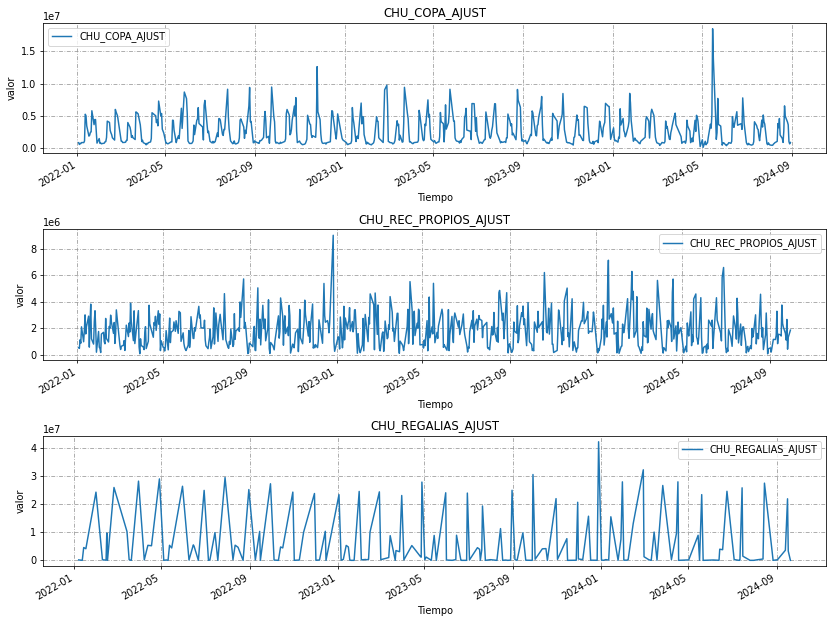

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=70)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes, axes)):
    funciones.graficar_serie(serie=df,
             titulo=f"{df.name}",
             xlabel="Tiempo",
             ylabel="valor",
             ax=ax)

plt.tight_layout()  # Evitar superposición
plt.show()

In [5]:
display(HTML("<h2>Boxplot</h2>"))
funciones.graficar_boxplots(dataframes,titulos=titulos)

In [106]:
df = pd.DataFrame(dataframes[2].copy())

df["Year"] = df.index.year
df["Month"] = df.index.month
per = df.groupby(["Year", "Month"]).count()
# period_default  = int(df["Year"].value_counts().mean())
per.mean()

CHU_REGALIAS_AJUST    5.757576
dtype: float64

In [91]:
per = df.groupby([""])

FECHA
1     22
5     19
6     19
7     19
3     17
8     17
2     16
4     15
9     15
11    11
10    10
12    10
Name: count, dtype: int64

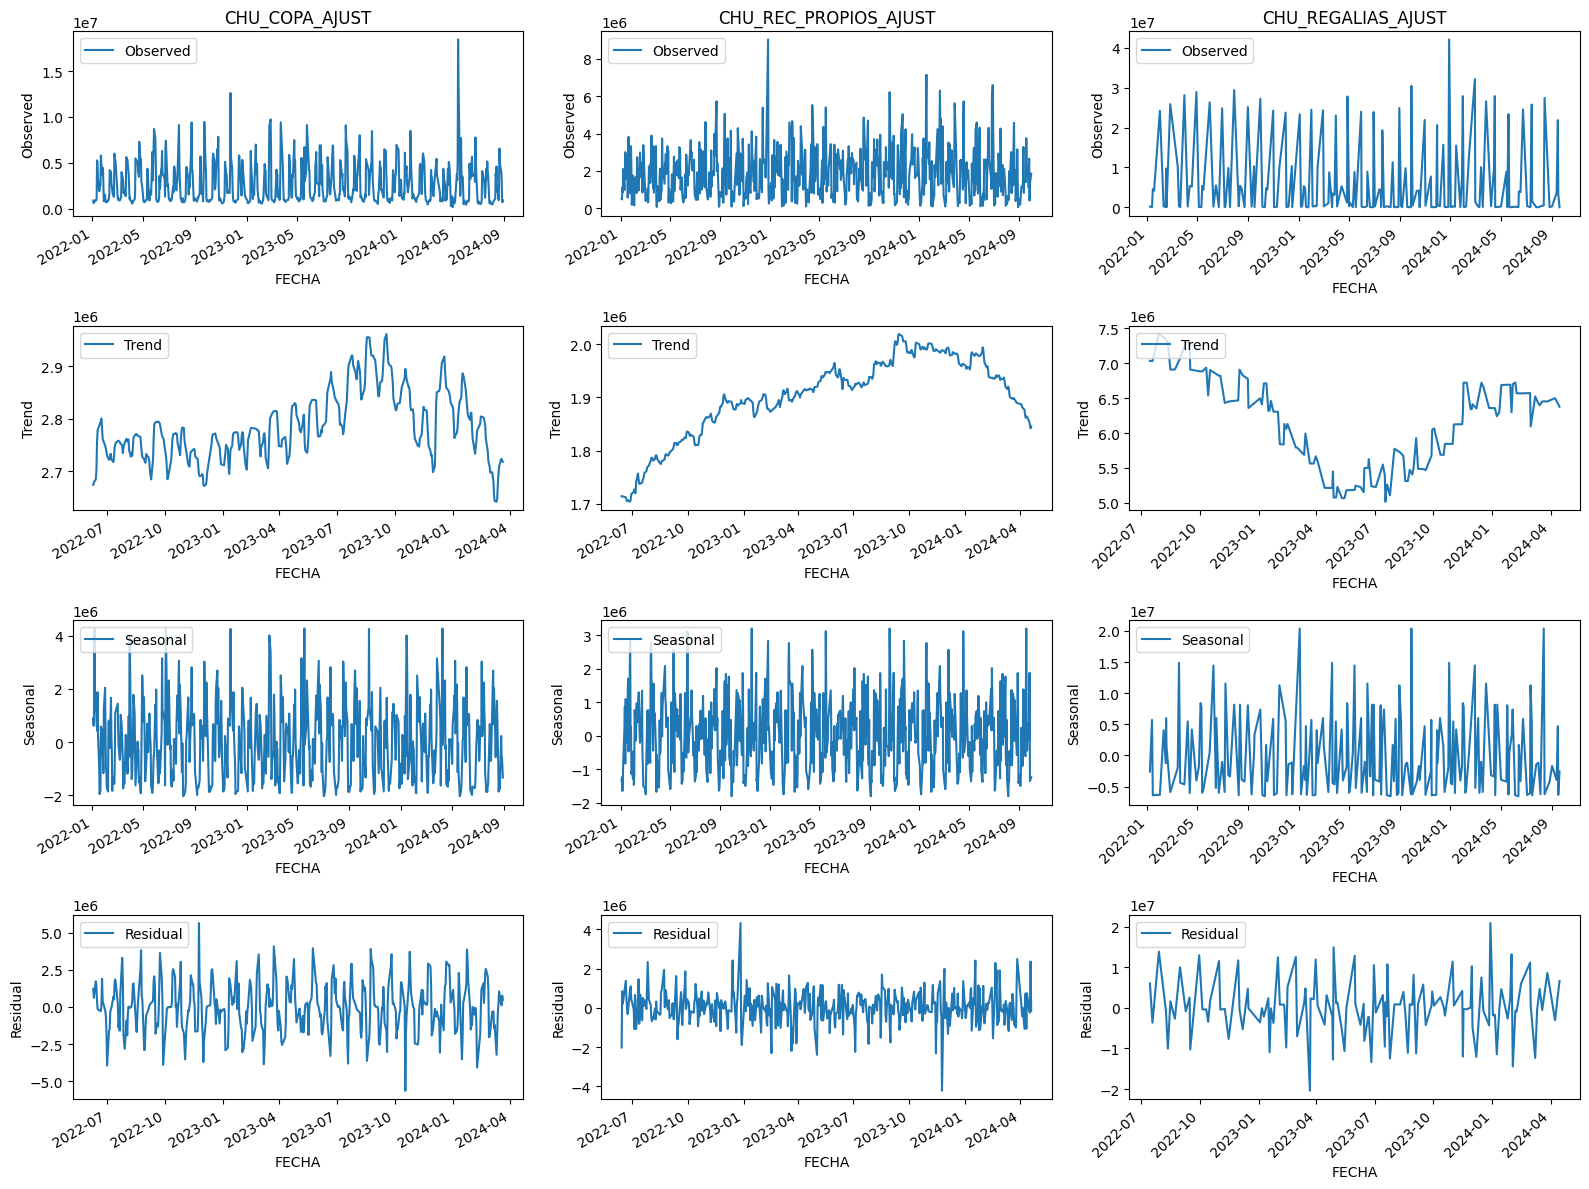

In [17]:
periodos = [211, 218, 63]
display(HTML("<h2>Descomposición de las series</h2>"))
funciones.componentes(dataframes, periodos, titulos)

<h2>Ejercicio 3</h2>
Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?.

Justificar con teoría.

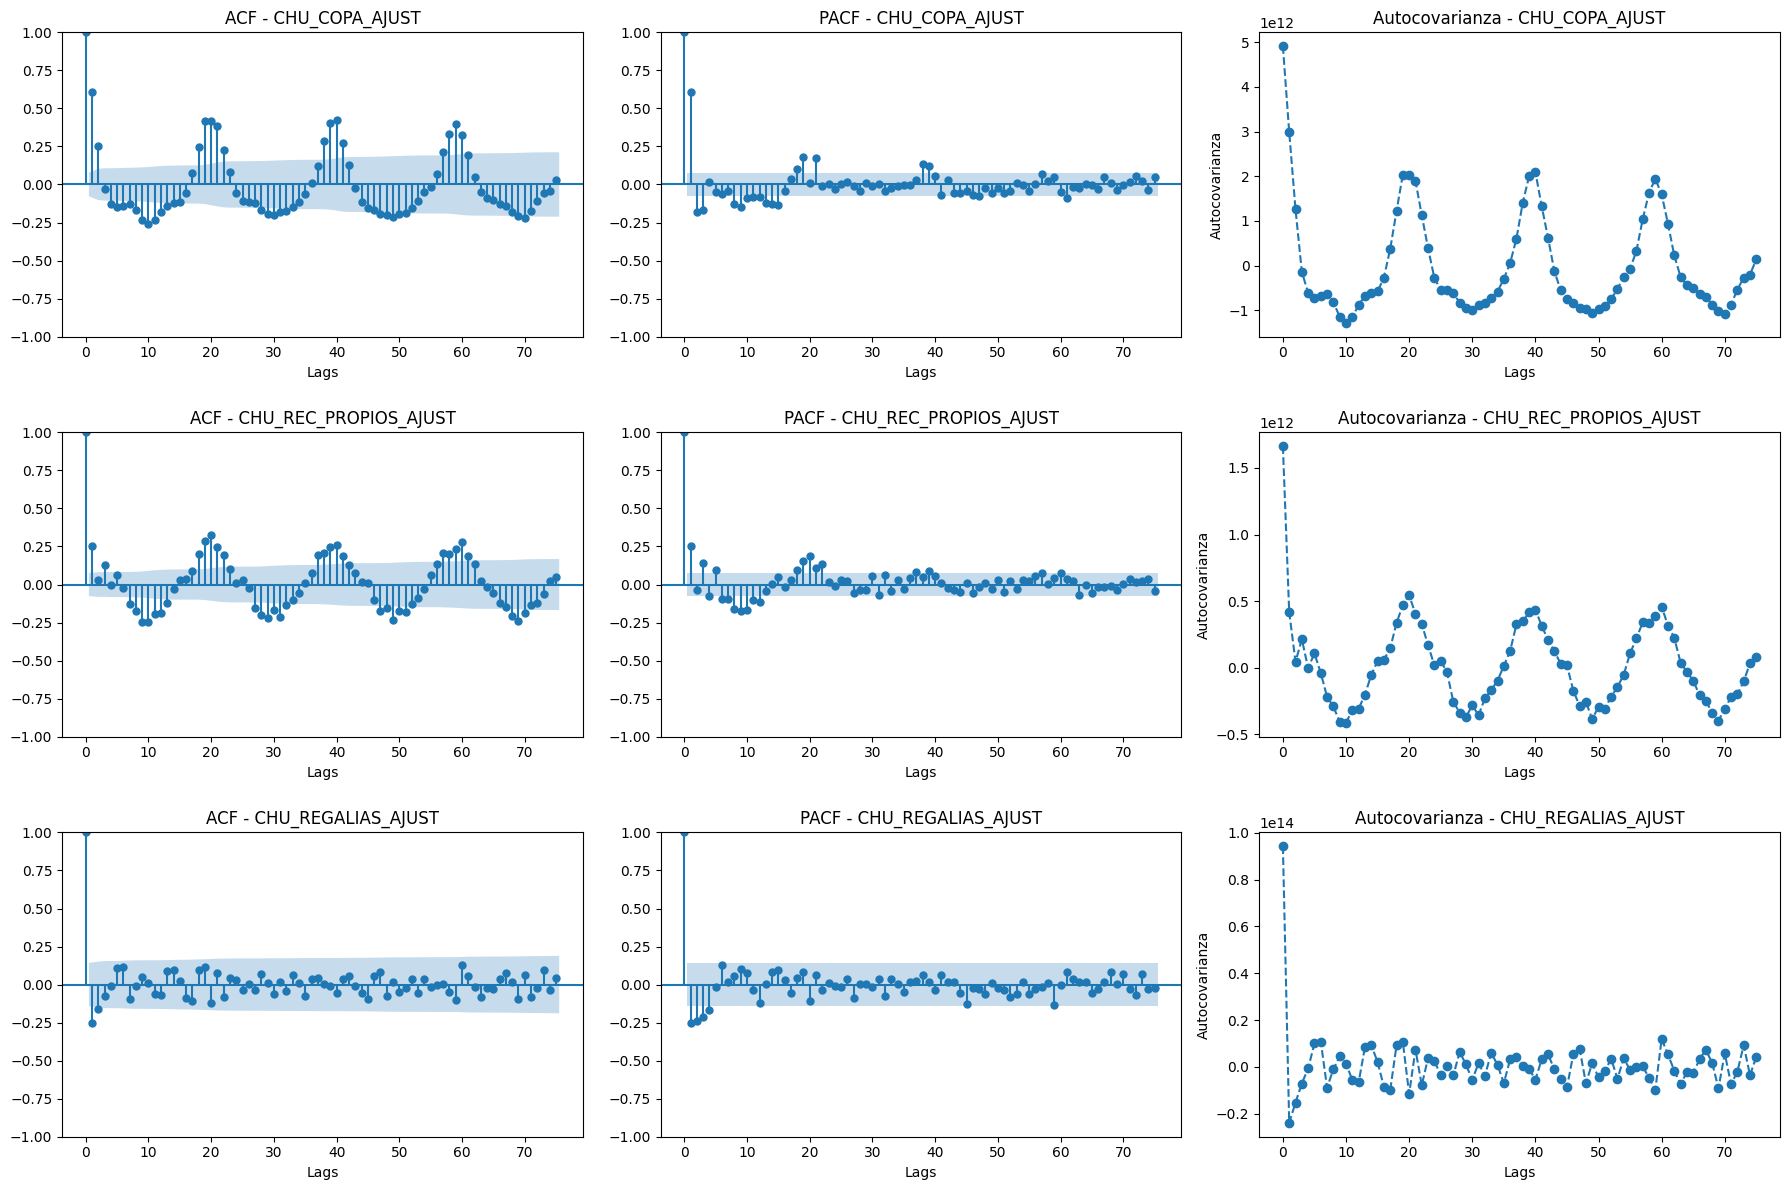

In [18]:
from importlib import reload
import funciones
reload(funciones)
funciones.multi_autocov_autocorr(dataframes,75,['a','b','c'])

#### SON ESTACIONARIAS PORQUE:
* FAC es sinusoidal en copa y REC
* Las autocorrelaciones se reducen exponencialmente en REGALIAS


*Vemos que en las tres series no hay estacionalidad porque no vemos picos que se repiten periodicamente. Parecen ser estancionarios, porque su PAC es sinusoidal y su PACF decrece exponencialmente.*

CHU_COPA_AJUST:

1. ACF (Autocorrelación):

* La función de autocorrelación (ACF) nos indica cómo los valores de la serie están correlacionados consigo mismos en diferentes retardos (lags).
* Interpretación: El primer lag muestra una autocorrelación muy alta (cercana a 1), lo cual es común en muchas series temporales, ya que cada punto está altamente correlacionado con el valor inmediato anterior. Luego, vemos una autocorrelación significativa hasta alrededor del lag 10. A partir de ahí, la autocorrelación disminuye y oscila, pero sigue mostrando valores positivos significativos en varios lags posteriores, lo que podría indicar un patrón de periodicidad o una estructura de largo plazo en la serie.
* Análisis: La presencia de autocorrelaciones significativas en varios lags indica que la serie tiene memoria, es decir, que el valor actual está influenciado por valores pasados más allá de los periodos cercanos. Esto sugiere que la serie tiene un componente estructural que necesita modelarse.

2. PACF (Autocorrelación Parcial):

* La función de autocorrelación parcial (PACF) nos ayuda a identificar la dependencia de un punto con sus retardos excluyendo las correlaciones intermedias, es decir, muestra la correlación directa de un punto con su propio retardo, eliminando el efecto de otros retardos.
* Interpretación: En el PACF vemos una caída abrupta después del primer lag, lo que significa que el valor actual está fuertemente influenciado solo por el valor inmediato anterior (lag 1), y las correlaciones en lags más largos se vuelven más débiles, aunque todavía hay algunas correlaciones significativas hasta aproximadamente el lag 20.
* Análisis: La fuerte caída después del lag 1 sugiere que un modelo AR(1) podría ser adecuado para capturar la dependencia en los datos. Sin embargo, las correlaciones parciales en otros lags podrían indicar la necesidad de un modelo con más términos o de incluir una parte de media móvil (MA) en un modelo ARIMA.

3. Autocovarianza:

* La autocovarianza muestra cómo varía la covarianza entre puntos separados por diferentes lags.
* Interpretación: La autocovarianza sigue una forma ondulante, lo que sugiere la presencia de un patrón cíclico o periódico en la serie. Este comportamiento es consistente con lo que observamos en la ACF, donde la correlación no decae de manera rápida.
* Análisis: Este patrón cíclico refuerza la idea de que hay un componente estacional o repetitivo en la serie que podría ser capturado con términos estacionales o de periodicidad en un modelo.

4. ¿Es estacionaria la serie?
A partir de la ACF y PACF, la serie no parece estacionaria, dado que:

* La autocorrelación no decae rápidamente a cero, lo que indica que hay memoria a largo plazo.
* La PACF sugiere que hay correlaciones significativas más allá del primer retardo.

Conclusión: La serie no es estacionaria, y sería recomendable aplicar técnicas como la diferenciación para convertirla en estacionaria antes de modelar. Además, si los picos en la ACF son persistentes y muestran un patrón cíclico, también se debería considerar un componente estacional en el modelo, como un SARIMA o algún ajuste para capturar las periodicidades.

##### CHU_REC_AJUST
1. ACF (Función de Autocorrelación):

* Muestra un patrón cíclico/estacional claro
* Los valores decaen lentamente
* Presenta oscilaciones periódicas significativas
* Esto sugiere que la serie NO es estacionaria
* El patrón cíclico parece tener una periodicidad aproximada de 15-20 lags

2. PACF (Función de Autocorrelación Parcial):

* Muestra correlaciones significativas en los primeros lags
* Después del lag 5-6, las correlaciones son menos significativas
* Se observan algunos picos significativos dispersos

4. Estacionariedad:

* La serie original NO es estacionaria debido a:
    * Patrones cíclicos claros
    * Decaimiento lento en ACF
    * Correlaciones significativas persistentes
* Existe una clara componente estacional en los datos originales

5. Para la serie original, sería necesario:

* Aplicar diferenciación para eliminar tendencia
* Considerar diferenciación estacional
* Posiblemente usar modelos SARIMA

CHU_REGALIAS_AJUST

1. ACF:

* Las correlaciones son mucho más débiles
* No hay un patrón cíclico claro
* La mayoría de los valores están dentro de las bandas de confianza
* Sugiere que la serie se ha vuelto más estacionaria

2. PACF:

* Correlaciones parciales significativas solo en los primeros lags
* Después del lag 5, casi todas las correlaciones están dentro de las bandas de confianza
* Estructura más limpia y menos ruidosa

3. Consideraciones:
* Podría modelarse con un ARIMA más simple
* Los órdenes del modelo podrían ser bajos dado el comportamiento de ACF/PACF
* Posiblemente un ARIMA(p,d,q) donde p y q serían pequeños

## Ejercicio 4
Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

Componentes deterministicos - Test de Raíces Unitarias - Dickey Fuller

Estos tests se utilizan para determinar si una serie de tiempo es estacionaria o no.

In [19]:
resultados_adf = funciones.test_dickeyfuller(dataframes, titulos)
display(HTML("<h2>Resultados de la prueba de Dickey-Fuller</h2>"))
display(resultados_adf)

Serie                                    CHU_COPA_AJUST  \
ADF (None)                                    -0.716012   
p-valor (None)                                 0.405863   
Críticos (None)     1%: -2.569, 5%: -1.941, 10%: -1.616   
Rechaza H0 (None)                                 False   
ADF (Drift)                                   -4.971131   
p-valor (Drift)                                0.000025   
Críticos (Drift)    1%: -3.441, 5%: -2.866, 10%: -2.569   
Rechaza H0 (Drift)                                 True   
ADF (Trend)                                   -4.971336   
p-valor (Trend)                                0.000232   
Críticos (Trend)    1%: -3.974, 5%: -3.418, 10%: -3.131   
Rechaza H0 (Trend)                                 True   

Serie                             CHU_REC_PROPIOS_AJUST  \
ADF (None)                                    -0.598842   
p-valor (None)                                 0.455111   
Críticos (None)     1%: -2.569, 5%: -1.941, 10%: -1.616   
Rechaza H0 (None)                                 False   
ADF (Drift)                                   -3.920887   
p-valor (Drift)                                0.001886   
Críticos (Drift)    1%: -3.441, 5%: -2.866, 10%: -2.569   
Rechaza H0 (Drift)                                 True   
ADF (Trend)                                   -3.942755   
p-valor (Trend)                                0.010587   
Críticos (Trend)    1%: -3.973, 5%: -3.417, 10%: -3.131   
Rechaza H0 (Trend)                                False   

Serie                                CHU_REGALIAS_AJUST  
ADF (None)                                    -0.838671  
p-valor (None)                                 0.354325  
Críticos (None)     1%: -2.579, 5%: -1.943, 10%: -1.615  
Rechaza H0 (None)                                 False  
ADF (Drift)                                  -10.685298  
p-valor (Drift)                                     0.0  
Críticos (Drift)    1%: -3.466, 5%: -2.877, 10%: -2.575  
Rechaza H0 (Drift)                                 True  
ADF (Trend)                                  -10.836002  
p-valor (Trend)                                     0.0  
Críticos (Trend)    1%: -4.008, 5%: -3.434, 10%: -3.141  
Rechaza H0 (Trend)                                 True

<b>Análisis de CHU_COPA_AJUST</b>

Test ADF sin drift ni tendencia:
* Estadístico ADF: -0.641313
* p-valor: 0.437307
* Interpretación: En este caso, el p-valor (0.437307) es mayor que los niveles de significancia comunes (0.01, 0.05, 0.1). Además, el estadístico ADF (-0.641313) es mayor que todos los valores críticos. Esto sugiere que no podemos rechazar la hipótesis nula de no estacionariedad. Es decir, según este test, la serie parece no ser estacionaria.

Test ADF con drift (constante):
* Estadístico ADF: -5.671137
* p-valor: 0.000001
* Interpretación: El p-valor es muy pequeño (0.000001 < 0.01) y el estadístico ADF (-5.671137) es menor que todos los valores críticos. Esto nos permite rechazar la hipótesis nula con un alto nivel de confianza. Según este test, la serie parece ser estacionaria alrededor de una constante.

Test ADF con tendencia:
* Estadístico ADF: -6.436652
* p-valor: 0.000000
* Interpretación: Al igual que en el caso anterior, el p-valor es extremadamente pequeño y el estadístico ADF es menor que todos los valores críticos. Podemos rechazar la hipótesis nula con un alto nivel de confianza. Este test sugiere que la serie es estacionaria alrededor de una tendencia.

Conclusión general:
Los resultados de estos tres tests muestran una imagen interesante:
* Sin considerar drift ni tendencia, la serie parece no estacionaria.
* Al considerar un término constante (drift), la serie muestra evidencia de estacionariedad.
* Al considerar tanto drift como tendencia, la serie muestra una fuerte evidencia de estacionariedad.

Esto sugiere que tu serie temporal probablemente tiene una tendencia y/o un nivel medio distinto de cero. La serie parece ser estacionaria una vez que se tienen en cuenta estos componentes.

Recomendaciones:
* Visualiza tu serie temporal para confirmar visualmente la presencia de una tendencia o un nivel medio distinto de cero.
* Considera diferenciar la serie si planeas usar modelos que requieran estacionariedad estricta.
* Si estás modelando la serie, podrías incluir términos de tendencia y/o constantes en tu modelo para capturar estos componentes.
* Ten en cuenta que la elección entre los modelos con drift y con tendencia dependerá de tu conocimiento del proceso que genera los datos y del comportamiento observado en la serie.

In [20]:
importlib.reload(funciones)
display(HTML("<h2>Resultados de la prueba de Augmented Dickey-Fuller</h2>"))
display(funciones.Augmented_Dickey_Fuller_Test_func2(dataframes))

Test Statistic   p-value No Lags No Obs  \
CHU_COPA_AJUST             -4.971131  0.000025      20    612   
CHU_REC_PROPIOS_AJUST      -3.920887  0.001886      20    635   
CHU_REGALIAS_AJUST        -10.685298       0.0       3    186   

                           Crit Val (1%,5%,10%) Estacionaria 5%  
CHU_COPA_AJUST         [-3.441, -2.866, -2.569]            True  
CHU_REC_PROPIOS_AJUST  [-3.441, -2.866, -2.569]            True  
CHU_REGALIAS_AJUST     [-3.466, -2.877, -2.575]            True

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. 
Las pruebas realizadas son:

* Prueba de Dickey-Fuller aumentada 
* Prueba de Kwiatkowski-Phillips-Schmidt-Shin
* Prueba de Phillips-Perron

In [21]:

display(funciones.estacionario2(dataframes))

ADF KPSS PP Should Diff ADFtest
CHU_COPA_AJUST          0    0  0       (0.01, False)
CHU_REC_PROPIOS_AJUST   0    0  0       (0.01, False)
CHU_REGALIAS_AJUST      0    0  0       (0.01, False)

*Según el test de KPSS debemos diferenciar 1 vez para que las series sean estacionarias*

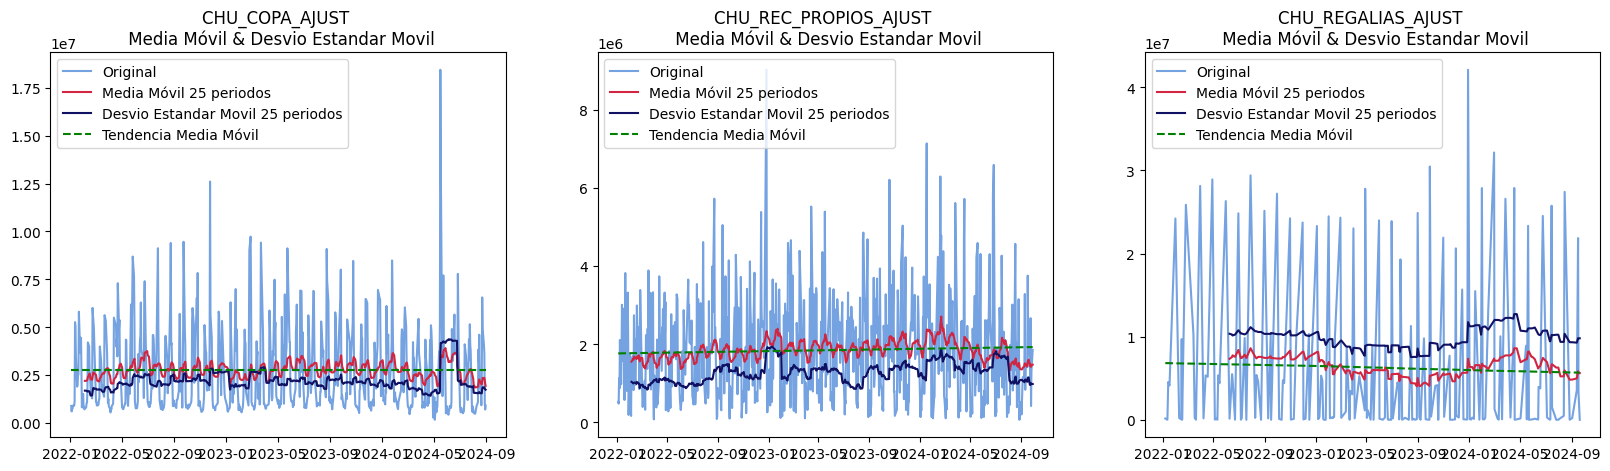

In [22]:

funciones.test_stationarity(dataframes)

#### PREGUNTA: EN BASE A LOS GRAFICOS DE ARRIBA........ ¿HACE FALTA APLICAR BOX-COX? PARA ESTABILIZAR LA VARIANZA....

1. Gráfico de la izquierda (CHU_COPA_AJUST):
* Descripción: Se observa la serie original (en azul claro), junto con una media móvil de 25 períodos (línea roja), un desvío estándar móvil de 25 períodos (línea azul oscuro) y una tendencia (línea verde punteada).
* Interpretación: La serie original muestra un comportamiento muy fluctuante, con picos pronunciados. Sin embargo, la media móvil y el desvío estándar parecen estabilizarse, sugiriendo cierta suavización en los valores. No obstante, la varianza no parece ser constante a lo largo del tiempo, dado que los picos y caídas en la serie son bastante marcados.
* Estacionariedad: Es poco probable que esta serie sea estacionaria, ya que muestra grandes variaciones en la magnitud (especialmente en los picos). Esto sugiere que la serie podría beneficiarse de transformaciones adicionales para estabilizar la varianza.

2. Gráfico del centro (CHU_REC_PROPIOS_AJUST):
* Descripción: Similar al primer gráfico, muestra la serie original, la media móvil, el desvío estándar móvil y la tendencia.
* Interpretación: La serie también presenta fluctuaciones importantes, aunque los picos no son tan extremos como en la serie anterior. La media móvil parece mantenerse relativamente constante a lo largo del tiempo, pero la varianza sigue mostrando incrementos y disminuciones notables.
* Estacionariedad: Tampoco parece ser estacionaria, ya que los valores de la serie original varían significativamente en diferentes períodos. Aunque la media móvil es estable, el desvío estándar refleja variaciones en la dispersión de los datos.

3. Gráfico de la derecha (CHU_REGALIAS_AJUST):
* Descripción: Igual que los gráficos anteriores, muestra la serie original junto con la media móvil, desvío estándar móvil y tendencia.
* Interpretación: Esta serie tiene fluctuaciones marcadas, con algunos picos importantes. La media móvil muestra una leve tendencia ascendente, mientras que el desvío estándar también varía, indicando que la dispersión de los datos no es constante.
* Estacionariedad: Al igual que en los casos anteriores, la serie no parece estacionaria debido a la variabilidad en la magnitud de los datos.


¿Es necesaria la transformación de Box-Cox?
La transformación de Box-Cox puede ser útil para estabilizar la varianza en series temporales con fluctuaciones grandes. En estos gráficos, la varianza no parece ser constante (heterocedasticidad), ya que los picos varían mucho en diferentes puntos del tiempo. Aplicar una transformación como Box-Cox podría ayudar a hacer la varianza más estable y, potencialmente, facilitar el análisis de las series, especialmente si planeas modelarlas con métodos que requieren estacionariedad.

Resumen:
* Ninguna de las series parece ser estacionaria.
* La transformación de Box-Cox podría ser recomendable para estabilizar la varianza y hacer que las series sean más apropiadas para el modelado.

<h3>Auto Arima</h3>

<h4>CHU_COPA_AJUST</h4>

Serie original

In [52]:
models = []

In [53]:
aa_chu_copa_ajust = auto_arima(dataframes[0], trace=True,suppress_warnings=True)
models.append({
    "modelo": aa_chu_copa_ajust,
    "titulo": "aa_df0",
    "aic": aa_chu_copa_ajust.aic(),
    "order": aa_chu_copa_ajust.order
})

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19976.618, Time=2.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20298.311, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20006.761, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20072.811, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20878.440, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=19981.848, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19993.323, Time=0.99 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=19975.115, Time=1.25 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=19973.886, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19971.943, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=19987.582, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=19973.754, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=19975.736, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=20094.441, Time=0.05 sec

Best model:  ARIMA

<h4>CHU_REC_PROPIOS_AJUST</h4>

Serie original

In [55]:
aa_rec_propios_ajus = auto_arima(dataframes[1], trace=True,suppress_warnings=True)
models.append({
    "modelo": aa_rec_propios_ajus,
    "titulo": "aa_df1",
    "aic": aa_rec_propios_ajus.aic(),
    "order": aa_rec_propios_ajus.order
})

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20267.189, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20325.278, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20284.482, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20281.247, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21048.386, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20283.968, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20288.273, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=20267.945, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=20267.303, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20286.571, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20268.321, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20275.996, Time=0.20 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=20276.631, Time=1.85 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.19 sec

Best model:  ARIMA(2,0,2

<h4>CHU_REGALIAS_AJUST</h4>

Serie original

In [56]:
aa_rec_regalias_ajus = auto_arima(dataframes[2], trace=True,suppress_warnings=True)
models.append({
    "modelo": aa_rec_regalias_ajus,
    "titulo": "aa_df2",
    "aic": aa_rec_regalias_ajus.aic(),
    "order": aa_rec_regalias_ajus.order
})

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6633.407, Time=1.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6656.772, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6646.098, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6640.490, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6721.796, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6633.596, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6643.260, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6631.602, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6630.874, Time=0.74 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6629.520, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6636.517, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6626.038, Time=0.58 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6627.989, Time=0.95 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6628.020, Time=0.34 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=6629.995, Time=0.58 sec
 ARIMA(4,0

In [57]:
pd.DataFrame(models)

modelo  titulo           aic      order
0   ARIMA(3,0,0)(0,0,0)[0] intercept  aa_df0  19971.943321  (3, 0, 0)
1   ARIMA(2,0,2)(0,0,0)[0] intercept  aa_df1  20267.189138  (2, 0, 2)
2   ARIMA(4,0,0)(0,0,0)[0] intercept  aa_df2   6626.037901  (4, 0, 0)

<h3>Modelos ARMA</h3>

In [27]:
import itertools
import statsmodels.api as sm

p_values = range(0, 8)
q_values = range(0, 8)

def modelo_arma(df):

    resultados = []
    mejor_aic = float("inf")
    mejor_order = None
    mejor_modelo = None


    for p, q in itertools.product(p_values, q_values):
        try:

            modelo = sm.tsa.arima.ARIMA(df, order=(p, 0, q))
            resultado = modelo.fit()

            aic = resultado.aic
            resultados.append((p, q, aic))

            if aic < mejor_aic:
                mejor_aic = aic
                mejor_order = (p, q)
                mejor_modelo = resultado

        except Exception as e:
            print(f"Error en el modelo ARMA({p},{q}): {e}")

    print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

    for p, q, aic in resultados:
        print(f"ARMA({p},{q}) AIC: {aic}")

<h4>CHU_COPA_AJUST</h4>

Serie original

In [28]:
modelo_arma(dataframes[0])

Mejor modelo ARMA: order=(6, 3) con AIC=19891.61742095838
ARMA(0,0) AIC: 23749.45836999389
ARMA(0,1) AIC: 20064.080511225846
ARMA(0,2) AIC: 19979.2585784847
ARMA(0,3) AIC: 19977.883385016314
ARMA(0,4) AIC: 19982.239386713296
ARMA(0,5) AIC: 19984.864751950296
ARMA(0,6) AIC: 19979.418255690332
ARMA(0,7) AIC: 19976.457397275804
ARMA(1,0) AIC: 20006.762218512442
ARMA(1,1) AIC: 19995.521655878845
ARMA(1,2) AIC: 19977.384044194896
ARMA(1,3) AIC: 19978.708160932176
ARMA(1,4) AIC: 19955.238890230652
ARMA(1,5) AIC: 19953.698852044727
ARMA(1,6) AIC: 19952.82680143384
ARMA(1,7) AIC: 19954.89760788955
ARMA(2,0) AIC: 19987.58022292064
ARMA(2,1) AIC: 19951.499423036672
ARMA(2,2) AIC: 19976.236726134517
ARMA(2,3) AIC: 19948.89233572508
ARMA(2,4) AIC: 19925.39424509018
ARMA(2,5) AIC: 19975.784579916886
ARMA(2,6) AIC: 19954.958409822444
ARMA(2,7) AIC: 19957.7101026972
ARMA(3,0) AIC: 19971.939177783934
ARMA(3,1) AIC: 19973.60220783262
ARMA(3,2) AIC: 19954.702449729884
ARMA(3,3) AIC: 19949.648432463495
A

In [59]:
models.append({
    "modelo": "ARMA(6, 3)",
    "titulo": "arma_df0",
    "aic": 19891.61742095838,
    "order": "(6, 3)"})

<h4>CHU_REC_PROPIOS_AJUST</h4>

Serie original

In [29]:
modelo_arma(dataframes[1])

Mejor modelo ARMA: order=(2, 7) con AIC=20141.54667680626
ARMA(0,0) AIC: 23925.19966083935
ARMA(0,1) AIC: 20280.10526509802
ARMA(0,2) AIC: 20279.62428038489
ARMA(0,3) AIC: 20265.600314582654
ARMA(0,4) AIC: 20267.609965634947
ARMA(0,5) AIC: 20265.23981704526
ARMA(0,6) AIC: 20262.215440716784
ARMA(0,7) AIC: 20264.069703557794
ARMA(1,0) AIC: 20284.480891111743
ARMA(1,1) AIC: 20271.64001664141
ARMA(1,2) AIC: 20270.692860194787
ARMA(1,3) AIC: 20266.385504504833
ARMA(1,4) AIC: 20269.226552791573
ARMA(1,5) AIC: 20272.536705371218
ARMA(1,6) AIC: 20258.13552460407
ARMA(1,7) AIC: 20246.43151369023
ARMA(2,0) AIC: 20285.53471715327
ARMA(2,1) AIC: 20269.219584271705
ARMA(2,2) AIC: 20267.121159329734
ARMA(2,3) AIC: 20272.52190016913
ARMA(2,4) AIC: 20270.797161907263
ARMA(2,5) AIC: 20273.54959423678
ARMA(2,6) AIC: 20142.37354908478
ARMA(2,7) AIC: 20141.54667680626
ARMA(3,0) AIC: 20274.53830422414
ARMA(3,1) AIC: 20265.271585802122
ARMA(3,2) AIC: 20269.61544737991
ARMA(3,3) AIC: 20189.29739526855
ARMA(

In [60]:
models.append({
    "modelo": "ARMA(2, 7)",
    "titulo": "arma_df1",
    "aic": 20141.54667680626,
    "order": "(2, 7)"})

Serie diferenciada

<h4>CHU_REGALIAS_AJUST</h4>

Serie original

In [30]:
modelo_arma(dataframes[2])

Mejor modelo ARMA: order=(2, 2) con AIC=6622.49558418637
ARMA(0,0) AIC: 7464.707051790934
ARMA(0,1) AIC: 6632.64175558783
ARMA(0,2) AIC: 6628.430260157915
ARMA(0,3) AIC: 6630.100040735028
ARMA(0,4) AIC: 6627.610937001355
ARMA(0,5) AIC: 6625.8875176672955
ARMA(0,6) AIC: 6627.669770891289
ARMA(0,7) AIC: 6626.188127085561
ARMA(1,0) AIC: 6646.097575167638
ARMA(1,1) AIC: 6629.960391534383
ARMA(1,2) AIC: 6630.314569392904
ARMA(1,3) AIC: 6627.170405599414
ARMA(1,4) AIC: 6627.394012185026
ARMA(1,5) AIC: 6627.8140173076645
ARMA(1,6) AIC: 6628.560580086201
ARMA(1,7) AIC: 6628.006781455379
ARMA(2,0) AIC: 6636.516259691306
ARMA(2,1) AIC: 6628.741731499358
ARMA(2,2) AIC: 6622.49558418637
ARMA(2,3) AIC: 6623.960025249578
ARMA(2,4) AIC: 6625.883752600026
ARMA(2,5) AIC: 6625.298413688528
ARMA(2,6) AIC: 6624.175272981167
ARMA(2,7) AIC: 6626.006208023041
ARMA(3,0) AIC: 6629.520883851206
ARMA(3,1) AIC: 6628.28191710817
ARMA(3,2) AIC: 6623.872978574133
ARMA(3,3) AIC: 6625.955968391097
ARMA(3,4) AIC: 6627.

In [61]:
models.append({
    "modelo": "ARMA(2, 2)",
    "titulo": "arma_df2",
    "aic": 6622.49558418637,
    "order": "(2, 2)"})

In [62]:
pd.DataFrame(models)

modelo    titulo           aic      order
0   ARIMA(3,0,0)(0,0,0)[0] intercept    aa_df0  19971.943321  (3, 0, 0)
1   ARIMA(2,0,2)(0,0,0)[0] intercept    aa_df1  20267.189138  (2, 0, 2)
2   ARIMA(4,0,0)(0,0,0)[0] intercept    aa_df2   6626.037901  (4, 0, 0)
3                         ARMA(6, 3)  arma_df0  19891.617421     (6, 3)
4                         ARMA(2, 7)  arma_df1  20141.546677     (2, 7)
5                         ARMA(2, 2)  arma_df2   6622.495584     (2, 2)

<h3> Métricas para modelos de autoarima automatico y manual </h3>

<h4>CHU_COPA_AJUST</h4>

Modelo 1: AUTOARIMA - ARIMA(3,0,0)(0,0,0)[0] intercept

In [72]:
modelo_aa_ARIMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(3,0,0))
resultado_aa_ARIMA_copa = modelo_aa_ARIMA_copa.fit()
resultado_aa_ARIMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                  633
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -9980.970
Date:              vie., 25 oct. 2024   AIC                          19971.939
Time:                        20:25:25   BIC                          19994.192
Sample:                             0   HQIC                         19980.581
                                - 633                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.722e+06   1.35e+05     20.118      0.000    2.46e+06    2.99e+06
ar.L1          0.6894      0.037     18.694      0.000       0.617       0.762
ar.L2         -0.0623      0.044     -1.423      0.155      -0.148       0.023
ar.L3         -0.1657      0.044     -3.799      0.000      -0.251      -0.080
sigma2      2.911e+12      0.150   1.94e+13      0.000    2.91e+12    2.91e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2801.98
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             2.14
Prob(H) (two-sided):                  0.06   Kurtosis:                        12.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+38. Standard errors may be unstable.
"""

Modelo 2 ARMA(6,3)

In [74]:
modelo_ARMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(6,0,3))
modelo_ARMA_copa = modelo_ARMA_copa.fit()
modelo_ARMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                  633
Model:                 ARIMA(6, 0, 3)   Log Likelihood               -9934.809
Date:              vie., 25 oct. 2024   AIC                          19891.617
Time:                        20:26:00   BIC                          19940.573
Sample:                             0   HQIC                         19910.629
                                - 633                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.722e+06   2.07e-08   1.32e+14      0.000    2.72e+06    2.72e+06
ar.L1          1.4471      0.067     21.459      0.000       1.315       1.579
ar.L2          0.2917      0.147      1.982      0.048       0.003       0.580
ar.L3         -1.6051      0.131    -12.249      0.000      -1.862      -1.348
ar.L4          0.8205      0.075     10.880      0.000       0.673       0.968
ar.L5          0.1235      0.075      1.639      0.101      -0.024       0.271
ar.L6         -0.2379      0.045     -5.246      0.000      -0.327      -0.149
ma.L1         -0.8912      0.054    -16.383      0.000      -0.998      -0.785
ma.L2         -0.8774      0.098     -8.953      0.000      -1.069      -0.685
ma.L3          0.9701      0.051     18.915      0.000       0.870       1.071
sigma2      2.788e+12   4.61e-14   6.04e+25      0.000    2.79e+12    2.79e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              4558.21
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             2.20
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+41. Standard errors may be unstable.
"""

<h4>CHU_REC_PROPIOS_AJUST</h4>

In [77]:
modelo_aa_ARIMA_RP= sm.tsa.arima.ARIMA(dataframes[1], order=(2,0,2))
modelo_aa_ARIMA_RP = modelo_aa_ARIMA_RP.fit()
modelo_aa_ARIMA_RP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CHU_REC_PROPIOS_AJUST   No. Observations:                  656
Model:                    ARIMA(2, 0, 2)   Log Likelihood              -10127.561
Date:                 vie., 25 oct. 2024   AIC                          20267.121
Time:                           20:27:57   BIC                          20294.038
Sample:                                0   HQIC                         20277.557
                                   - 656                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.833e+06   7.14e+04     25.685      0.000    1.69e+06    1.97e+06
ar.L1         -0.0354      0.339     -0.104      0.917      -0.700       0.629
ar.L2          0.3643      0.140      2.610      0.009       0.091       0.638
ma.L1          0.3374      0.345      0.977      0.329      -0.339       1.014
ma.L2         -0.3769      0.230     -1.641      0.101      -0.827       0.073
sigma2      1.502e+12      0.040   3.76e+13      0.000     1.5e+12     1.5e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               187.41
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+28. Standard errors may be unstable.
"""

In [78]:
modelo_ARMA_RP = sm.tsa.arima.ARIMA(dataframes[1], order=(2,0,7))
modelo_ARMA_RP = modelo_ARMA_RP.fit()
modelo_ARMA_RP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CHU_REC_PROPIOS_AJUST   No. Observations:                  656
Model:                    ARIMA(2, 0, 7)   Log Likelihood              -10059.773
Date:                 vie., 25 oct. 2024   AIC                          20141.547
Time:                           20:28:30   BIC                          20190.894
Sample:                                0   HQIC                         20160.679
                                   - 656                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.833e+06   5.28e-08   3.47e+13      0.000    1.83e+06    1.83e+06
ar.L1          1.8986      0.002   1121.011      0.000       1.895       1.902
ar.L2         -0.9990      0.002   -604.133      0.000      -1.002      -0.996
ma.L1         -1.8194      0.041    -44.767      0.000      -1.899      -1.740
ma.L2          0.6269      0.081      7.736      0.000       0.468       0.786
ma.L3          0.5255      0.090      5.870      0.000       0.350       0.701
ma.L4         -0.3307      0.100     -3.308      0.001      -0.527      -0.135
ma.L5          0.2309      0.098      2.351      0.019       0.038       0.424
ma.L6         -0.2382      0.095     -2.515      0.012      -0.424      -0.053
ma.L7          0.0899      0.045      1.991      0.046       0.001       0.178
sigma2      1.363e+12   4.07e-14   3.35e+25      0.000    1.36e+12    1.36e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               297.27
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+41. Standard errors may be unstable.
"""

<h4>CHU_REGALIAS_AJUST</h4>

In [79]:
modelo_aa_ARIMA_REG= sm.tsa.arima.ARIMA(dataframes[2], order=(4,0,0))
modelo_aa_ARIMA_REG = modelo_aa_ARIMA_REG.fit()
modelo_aa_ARIMA_REG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     CHU_REGALIAS_AJUST   No. Observations:                  190
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -3307.020
Date:              vie., 25 oct. 2024   AIC                           6626.040
Time:                        20:29:20   BIC                           6645.522
Sample:                             0   HQIC                          6633.932
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.313e+06   4.05e+05     15.607      0.000    5.52e+06    7.11e+06
ar.L1         -0.4067      0.120     -3.387      0.001      -0.642      -0.171
ar.L2         -0.3655      0.136     -2.694      0.007      -0.631      -0.100
ar.L3         -0.2793      0.088     -3.165      0.002      -0.452      -0.106
ar.L4         -0.1689      0.064     -2.632      0.008      -0.295      -0.043
sigma2      7.751e+13      0.014   5.53e+15      0.000    7.75e+13    7.75e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.40
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             1.12
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+30. Standard errors may be unstable.
"""

In [80]:
modelo_ARMA_REG = sm.tsa.arima.ARIMA(dataframes[2], order=(2,0,2))
modelo_ARMA_REG = modelo_ARMA_REG.fit()
modelo_ARMA_REG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     CHU_REGALIAS_AJUST   No. Observations:                  190
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3305.248
Date:              vie., 25 oct. 2024   AIC                           6622.496
Time:                        20:29:45   BIC                           6641.978
Sample:                             0   HQIC                          6630.388
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.313e+06   5.19e+05     12.162      0.000     5.3e+06    7.33e+06
ar.L1          0.9376      0.196      4.787      0.000       0.554       1.321
ar.L2         -0.5396      0.153     -3.532      0.000      -0.839      -0.240
ma.L1         -1.3436      0.174     -7.735      0.000      -1.684      -1.003
ma.L2          0.6924      0.137      5.064      0.000       0.424       0.960
sigma2      7.727e+13      0.023    3.4e+15      0.000    7.73e+13    7.73e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.93
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             1.08
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+42. Standard errors may be unstable.
"""

## Ejercicio 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).

In [86]:
# Model SARIMA
smodel_copa = auto_arima(dataframes[0],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=21, # Seleccionamos 21 para comparar series diarias con estacionalidad mensual
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_copa.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[21] intercept   : AIC=20217.470, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[21] intercept   : AIC=20298.311, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[21] intercept   : AIC=19978.517, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[21] intercept   : AIC=20024.583, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[21]             : AIC=20878.440, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[21] intercept   : AIC=20006.761, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[21] intercept   : AIC=19980.032, Time=3.20 sec
 ARIMA(1,0,0)(1,0,1)[21] intercept   : AIC=19978.721, Time=0.96 sec
 ARIMA(1,0,0)(0,0,1)[21] intercept   : AIC=19979.104, Time=0.42 sec
 ARIMA(1,0,0)(2,0,1)[21] intercept   : AIC=19980.199, Time=5.03 sec
 ARIMA(0,0,0)(1,0,0)[21] intercept   : AIC=20263.214, Time=0.24 sec
 ARIMA(2,0,0)(1,0,0)[21] intercept   : AIC=19954.587, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[21] intercept   : AIC=19987.582, Time=0.07 sec
 ARIMA(2,0,0)(2,0,0)[21] intercept   : AIC=19956.587, Time=3.34 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  633
Model:             SARIMAX(3, 0, 0)x(0, 0, [1, 2], 21)   Log Likelihood               -9964.390
Date:                               vie., 25 oct. 2024   AIC                          19942.780
Time:                                         20:44:42   BIC                          19973.933
Sample:                                              0   HQIC                         19954.878
                                                 - 633                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.474e+06    1.7e+05      8.674      0.000    1.14e+06    1.81e+06
ar.L1          0.6662      0.038     17.463      0.000       0.591       0.741
ar.L2         -0.1171      0.048     -2.436      0.015      -0.211      -0.023
ar.L3         -0.1146      0.044     -2.607      0.009      -0.201      -0.028
ma.S.L21       0.2354      0.032      7.426      0.000       0.173       0.298
ma.S.L42       0.1038      0.044      2.353      0.019       0.017       0.190
sigma2      2.911e+12      0.108    2.7e+13      0.000    2.91e+12    2.91e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              3244.36
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             2.15
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.32e+27. Standard errors may be unstable.
"""

In [88]:
# Model SARIMA
smodel_rec_prop = auto_arima(dataframes[1],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=21, # Seleccionamos 21 para comparar series diarias con estacionalidad mensual
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_rec_prop.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[21] intercept   : AIC=20294.580, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[21] intercept   : AIC=20325.278, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[21] intercept   : AIC=20273.754, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[21] intercept   : AIC=20271.010, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[21]             : AIC=21048.386, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[21] intercept   : AIC=20281.247, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[21] intercept   : AIC=20271.972, Time=1.67 sec
 ARIMA(0,0,1)(0,0,2)[21] intercept   : AIC=20268.085, Time=2.94 sec
 ARIMA(0,0,1)(1,0,2)[21] intercept   : AIC=20269.634, Time=18.82 sec
 ARIMA(0,0,0)(0,0,2)[21] intercept   : AIC=20287.343, Time=1.90 sec
 ARIMA(1,0,1)(0,0,2)[21] intercept   : AIC=20274.503, Time=3.65 sec
 ARIMA(0,0,2)(0,0,2)[21] intercept   : AIC=20261.822, Time=3.50 sec
 ARIMA(0,0,2)(0,0,1)[21] intercept   : AIC=20266.755, Time=0.50 sec
 ARIMA(0,0,2)(1,0,2)[21] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  656
Model:             SARIMAX(0, 0, 3)x(0, 0, [1, 2], 21)   Log Likelihood              -10119.616
Date:                               vie., 25 oct. 2024   AIC                          20253.232
Time:                                         20:50:14   BIC                          20284.636
Sample:                                              0   HQIC                         20265.408
                                                 - 656                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.774e+06   7.87e+04     22.552      0.000    1.62e+06    1.93e+06
ma.L1          0.2222      0.034      6.463      0.000       0.155       0.290
ma.L2         -0.0989      0.045     -2.221      0.026      -0.186      -0.012
ma.L3          0.1204      0.045      2.700      0.007       0.033       0.208
ma.S.L21       0.1670      0.042      3.975      0.000       0.085       0.249
ma.S.L42       0.0859      0.040      2.121      0.034       0.007       0.165
sigma2      1.516e+12      0.053   2.87e+13      0.000    1.52e+12    1.52e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               219.07
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+27. Standard errors may be unstable.
"""

In [109]:
# Model SARIMA
smodel_reg = auto_arima(dataframes[2],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=6, # Seleccionamos 21 para comparar series diarias con estacionalidad mensual
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_reg.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=6655.657, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=6656.772, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=6645.868, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=6635.536, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=6721.796, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=6640.490, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[6] intercept   : AIC=6631.445, Time=1.03 sec
 ARIMA(0,0,1)(1,0,0)[6] intercept   : AIC=6642.021, Time=0.57 sec
 ARIMA(0,0,1)(2,0,1)[6] intercept   : AIC=6633.287, Time=0.25 sec
 ARIMA(0,0,1)(1,0,2)[6] intercept   : AIC=6633.031, Time=0.23 sec
 ARIMA(0,0,1)(0,0,2)[6] intercept   : AIC=6636.918, Time=0.10 sec
 ARIMA(0,0,1)(2,0,0)[6] intercept   : AIC=6637.088, Time=0.12 sec
 ARIMA(0,0,1)(2,0,2)[6] intercept   : AIC=6634.883, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=6657.513, Time=0.07 sec
 ARIMA(1,0,1)(1,0,1)[6] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  190
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 6)   Log Likelihood               -3307.216
Date:                           vie., 25 oct. 2024   AIC                           6626.433
Time:                                     20:58:57   BIC                           6645.915
Sample:                                          0   HQIC                          6634.325
                                             - 190                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.718e+06   2.46e-08   3.14e+14      0.000    7.72e+06    7.72e+06
ma.L1         -0.4056      0.112     -3.632      0.000      -0.624      -0.187
ma.L2         -0.1607      0.116     -1.381      0.167      -0.389       0.067
ar.S.L6       -0.2196      0.075     -2.938      0.003      -0.366      -0.073
ma.S.L6        0.4159      0.108      3.867      0.000       0.205       0.627
sigma2      8.402e+13   1.19e-15   7.05e+28      0.000     8.4e+13     8.4e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.99
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.14
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+44. Standard errors may be unstable.
"""

## Ejercicio 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

In [3]:

###### PREGUNTA: DEBERIAMOS HACER VALIDACION CRUZADA NO????? CODIGO EN CLASE 4 - EJERCI 1

train_copa = dataframes[0].iloc[:round(len(dataframes[0])*.9)]
test_copa = dataframes[0].iloc[round(len(dataframes[0])*.9):]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:round(len(dataframes[1])*.9)]
test_recursos = dataframes[1].iloc[round(len(dataframes[1])*.9):]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:round(len(dataframes[2])*.9)]
test_regalias = dataframes[2].iloc[round(len(dataframes[2])*.9):]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((570,)), test((63,))
Recursos: train((590,)), test((66,))
Regalias: train((171,)), test((19,))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18006.296, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18295.589, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18035.932, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18092.388, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18822.147, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=18010.979, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18021.880, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=18004.723, Time=0.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=18003.604, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=18001.683, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18016.283, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=18003.412, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=18005.387, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=18115.975, Time=0.05 sec

Best model:  ARIMA

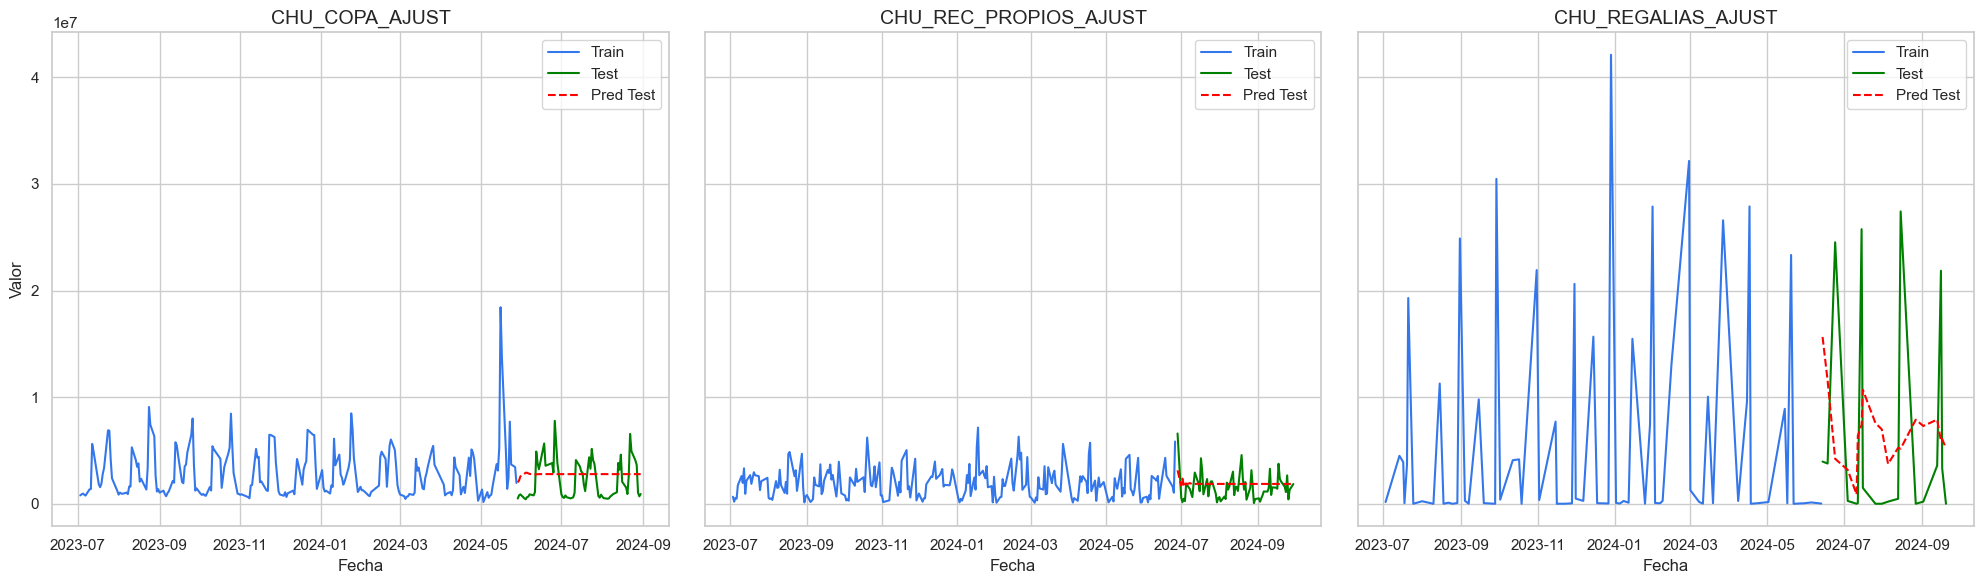

In [12]:
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    model = auto_arima(df_train, trace=True, suppress_warnings=True)

    # Cálculo del MSE en el conjunto de entrenamiento
    mape_train = mean_absolute_percentage_error(df_train, model.predict_in_sample())

    # Obtener el DataFrame de test correspondiente
    df_test = dataframes_test[i]
    pred_test = model.predict(len(df_test))
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    pred_test.index = df_test.index
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
funciones.plot_train_test_predictions(
dataframes_train=dataframes_train,
dataframes_test=dataframes_test,
predictions_test=predictions_test,
series_names=titulos,
start_date='2023-07-01'
)

In [13]:
pd.DataFrame(results_train_test)

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        570        63        0.67       1.74   
1  CHU_REC_PROPIOS_AJUST        590        66        1.35       1.99   
2     CHU_REGALIAS_AJUST        171        19    2,390.22   8,385.16   

   mape_mean  
0       1.36  
1       1.57  
2   9,889.84

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    model = ExponentialSmoothing(df_train,trend="add",seasonal='add', seasonal_periods=21).fit()
    df_test = dataframes_test[i]
    pred_train = model.predict(start=0, end=len(df_train) - 1)
    pred_test = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)
    pred_test.index = df_test.index
    predictions_test.append(pred_test)
    # Cálculo del MAPE para entrenamiento y prueba
    mape_train = mean_absolute_percentage_error(df_train, pred_train)
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
pd.DataFrame(results_train_test)

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        570        63        0.66       1.25   
1  CHU_REC_PROPIOS_AJUST        590        66        1.45       2.29   
2     CHU_REGALIAS_AJUST        171        19    1,693.65  10,941.29   

   mape_mean  
0       1.36  
1       1.57  
2   9,889.84

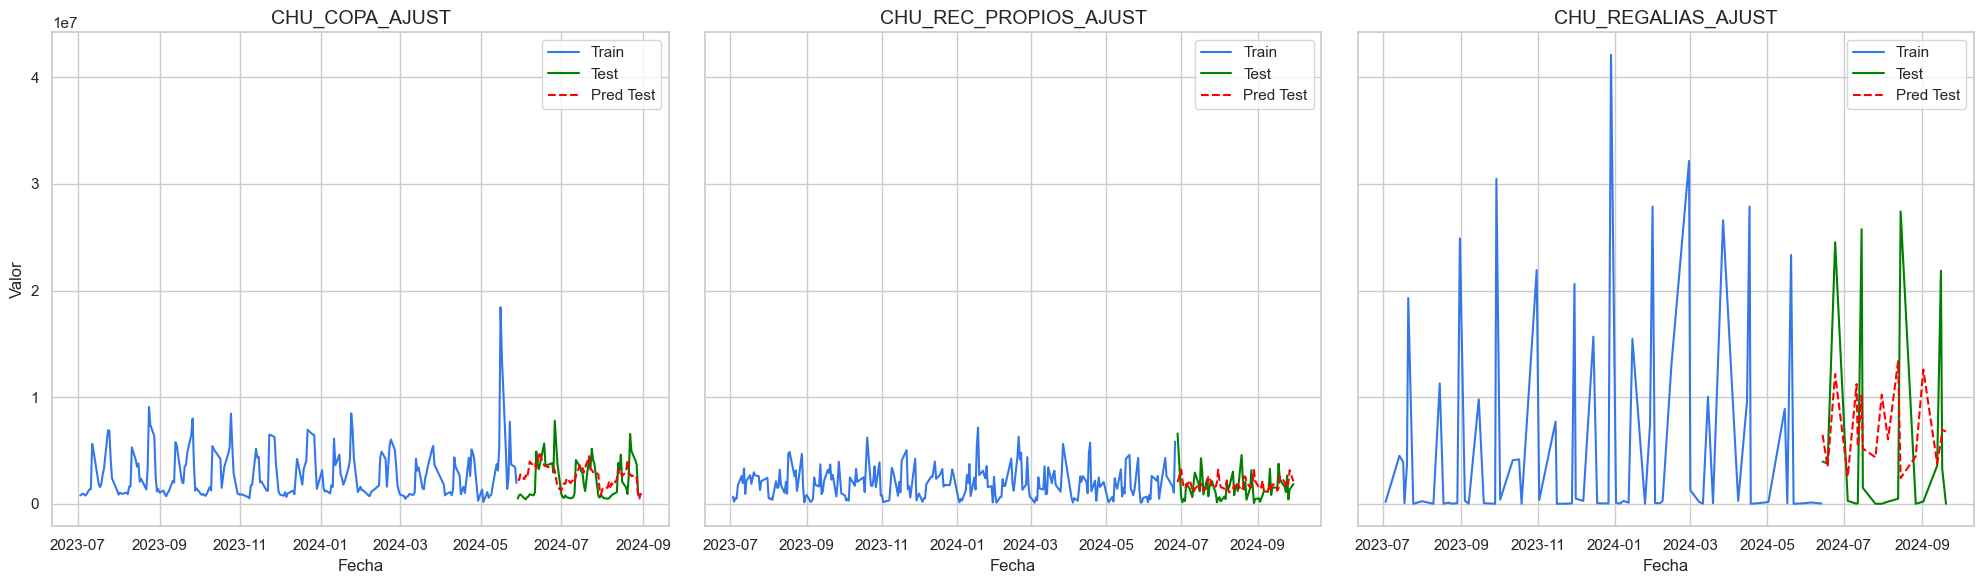

In [11]:

funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2023-07-01'
)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(gap=2, n_splits=5)

train_sets = []
test_sets = []

for i, (train_index, test_index) in enumerate(tscv.split(dataframes[0])):
    train_data = dataframes[0].iloc[train_index, 0]
    test_data = dataframes[0].iloc[test_index, 0]

    train_sets.append(train_data)
    test_sets.append(test_data)



train1, test1 = train_sets[0], test_sets[0]
train2, test2 = train_sets[1], test_sets[1]
train3, test3 = train_sets[2], test_sets[2]
train4, test4 = train_sets[3], test_sets[3]
train5, test5 = train_sets[4], test_sets[4]

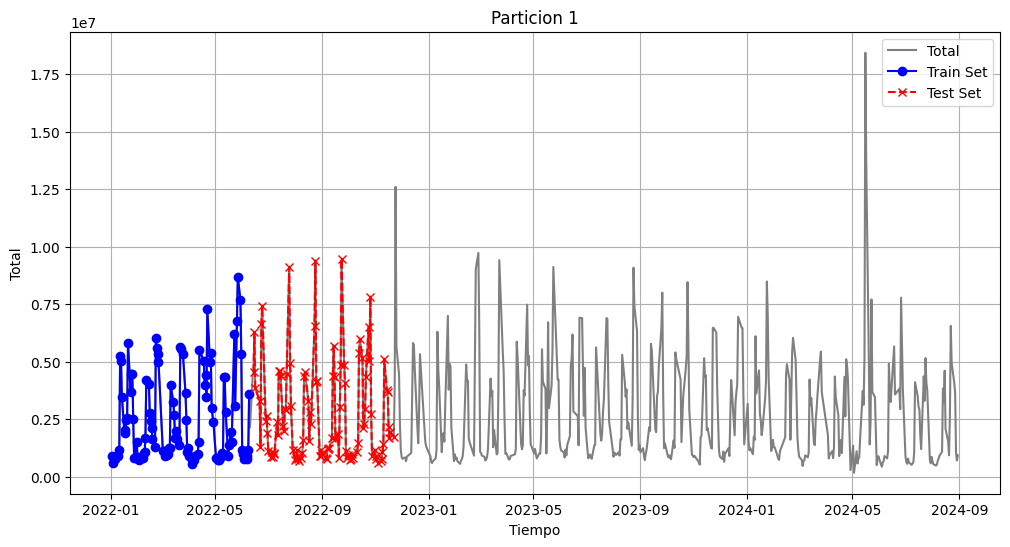

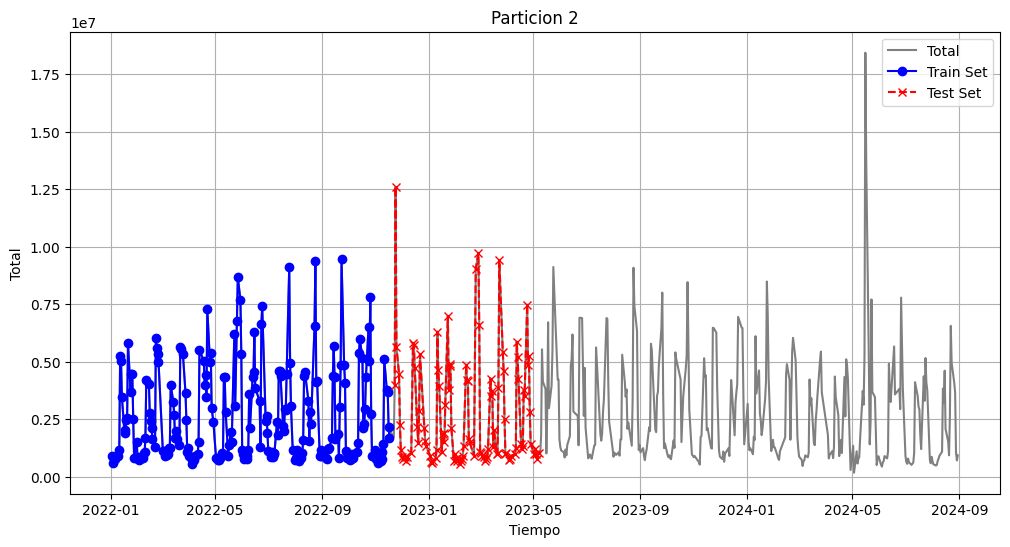

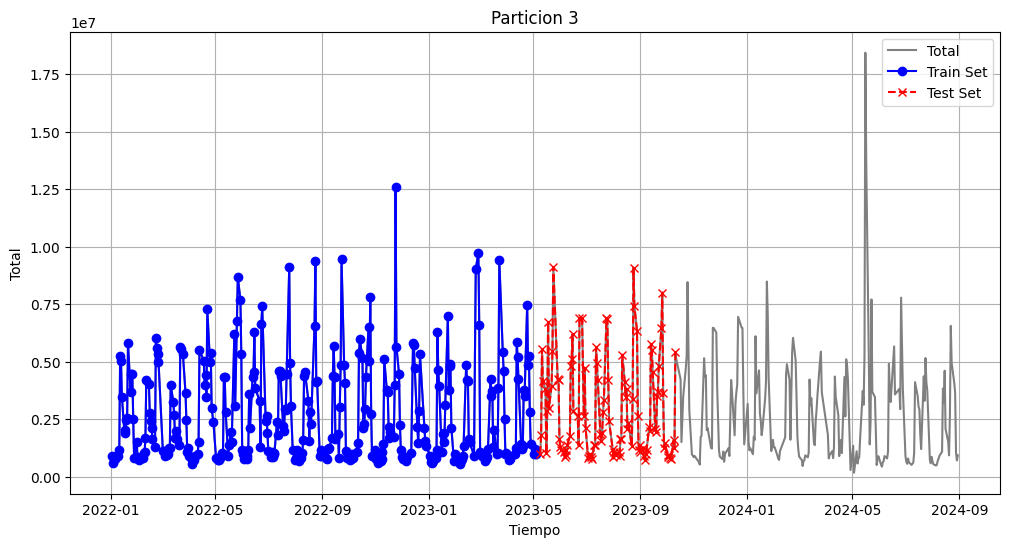

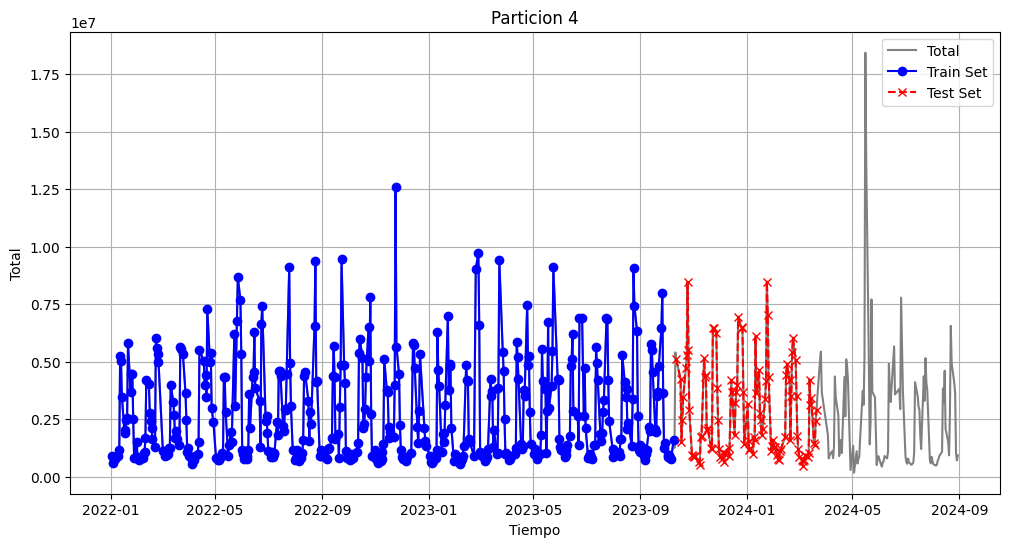

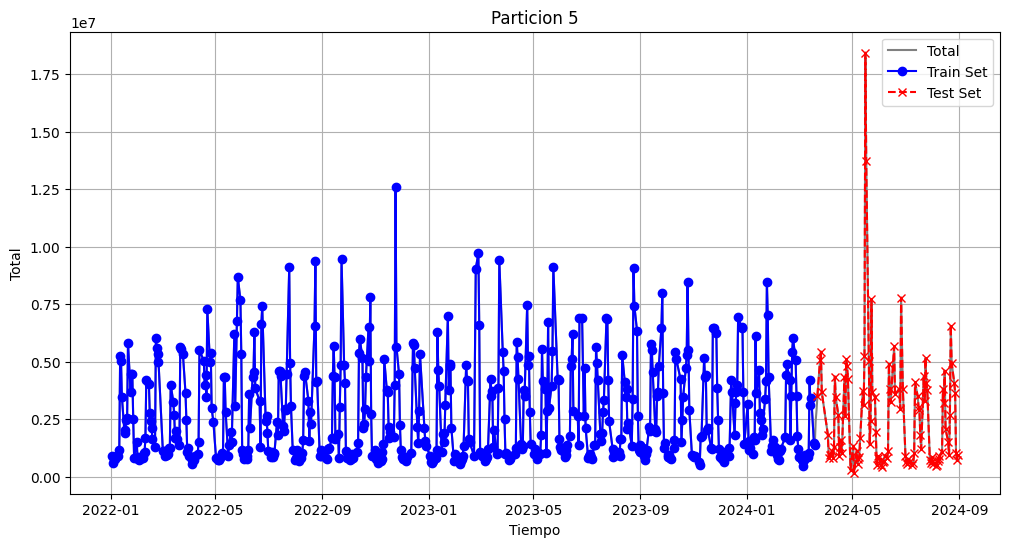

In [114]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(gap=2, n_splits=5)

def graficar_split(data, tscv):
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data, label='Total', color='grey')

        plt.plot(data.index[train_index], data.iloc[train_index], 'o-', label='Train Set', color='blue')
        plt.plot(data.index[test_index], data.iloc[test_index], 'x--', label='Test Set', color='red')

        plt.title(f'Particion {i + 1}')
        plt.xlabel('Tiempo')
        plt.ylabel('Total')
        plt.legend()
        plt.grid(True)
        plt.show()
        
graficar_split(dataframes[0], tscv)

Modelo ARMA

In [91]:
modelo_arma(dataframes_train[0])

Mejor modelo ARMA: order=(7, 7) con AIC=38213.676797460714
ARMA(0,0) AIC: 46277.611203049906
ARMA(0,1) AIC: 38524.66655388468
ARMA(0,2) AIC: 38423.10952471495
ARMA(0,3) AIC: 38413.48833513366
ARMA(0,4) AIC: 38417.11379372391
ARMA(0,5) AIC: 38413.26075297864
ARMA(0,6) AIC: 38389.14984388891
ARMA(0,7) AIC: 38385.66803177551
ARMA(1,0) AIC: 38439.41708600268
ARMA(1,1) AIC: 38438.16193976407
ARMA(1,2) AIC: 38416.19337898911
ARMA(1,3) AIC: 38403.264625526805
ARMA(1,4) AIC: 38374.02616655296
ARMA(1,5) AIC: 38367.49695455799
ARMA(1,6) AIC: 38365.31509453387
ARMA(1,7) AIC: 38368.59148479366
ARMA(2,0) AIC: 38436.024450431316
ARMA(2,1) AIC: 38367.53893247071
ARMA(2,2) AIC: 38397.67053526704
ARMA(2,3) AIC: 38359.84873630568
ARMA(2,4) AIC: 38286.39345952231
ARMA(2,5) AIC: 38286.83866156821
ARMA(2,6) AIC: 38256.21033090074
ARMA(2,7) AIC: 38372.28448932178
ARMA(3,0) AIC: 38398.96690972541
ARMA(3,1) AIC: 38361.779743816274
ARMA(3,2) AIC: 38361.148182596175
ARMA(3,3) AIC: 38361.61906133732
ARMA(3,4) AI

In [98]:
modelo_arma(dataframes_train_diff1[0])

Mejor modelo ARMA: order=(7, 6) con AIC=38312.041299925346
ARMA(0,0) AIC: 46160.817008211605
ARMA(0,1) AIC: 38680.873759303955
ARMA(0,2) AIC: 38511.17570772038
ARMA(0,3) AIC: 38415.167222522985
ARMA(0,4) AIC: 38401.91004359669
ARMA(0,5) AIC: 38400.31084188026
ARMA(0,6) AIC: 38393.97665482806
ARMA(0,7) AIC: 38358.8666881846
ARMA(1,0) AIC: 38691.44740031622
ARMA(1,1) AIC: 38444.51456806743
ARMA(1,2) AIC: 38432.00611881279
ARMA(1,3) AIC: 38407.46995768667
ARMA(1,4) AIC: 38403.78520173004
ARMA(1,5) AIC: 38402.47198443824
ARMA(1,6) AIC: 38400.48788354859
ARMA(1,7) AIC: 38325.435912836256
ARMA(2,0) AIC: 38687.2622742298
ARMA(2,1) AIC: 38437.5823074253
ARMA(2,2) AIC: 38432.07173639474
ARMA(2,3) AIC: 38391.57526961541
ARMA(2,4) AIC: 38344.41864173135
ARMA(2,5) AIC: 38387.3456174536
ARMA(2,6) AIC: 38398.55837342673
ARMA(2,7) AIC: 38329.176505786745
ARMA(3,0) AIC: 38649.239480908174
ARMA(3,1) AIC: 38408.00677547496
ARMA(3,2) AIC: 38342.67529165503
ARMA(3,3) AIC: 38341.25526264146
ARMA(3,4) AIC: 

In [92]:
arma_model_copa = sm.tsa.arima.ARIMA(dataframes_train[0], order=(7,0,7), trend='n')
resultado_arma_model_copa = arma_model_copa.fit()
resultado_arma_model_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1218
Model:                 ARIMA(7, 0, 7)   Log Likelihood              -19195.309
Date:                Sat, 19 Oct 2024   AIC                          38420.617
Time:                        16:36:53   BIC                          38497.192
Sample:                             0   HQIC                         38449.441
                               - 1218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3940      0.137    -10.140      0.000      -1.663      -1.125
ar.L2          0.5410      0.251      2.159      0.031       0.050       1.032
ar.L3          1.6710      0.132     12.695      0.000       1.413       1.929
ar.L4          0.2116      0.291      0.728      0.467      -0.358       0.781
ar.L5         -0.7022      0.220     -3.189      0.001      -1.134      -0.271
ar.L6          0.2110      0.110      1.918      0.055      -0.005       0.427
ar.L7          0.4615      0.073      6.326      0.000       0.319       0.605
ma.L1          1.9477      0.136     14.350      0.000       1.682       2.214
ma.L2          0.5696      0.328      1.736      0.083      -0.074       1.213
ma.L3         -1.4221      0.259     -5.490      0.000      -1.930      -0.914
ma.L4         -1.3013      0.206     -6.324      0.000      -1.705      -0.898
ma.L5         -0.2649      0.330     -0.803      0.422      -0.912       0.382
ma.L6         -0.2262      0.212     -1.067      0.286      -0.642       0.189
ma.L7         -0.2716      0.063     -4.340      0.000      -0.394      -0.149
sigma2      2.686e+12   2.26e-12   1.19e+24      0.000    2.69e+12    2.69e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3228.41
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.70
Prob(H) (two-sided):                  0.42   Kurtosis:                        10.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+39. Standard errors may be unstable.
"""

In [99]:
arma_model_copa_diff = sm.tsa.arima.ARIMA(dataframes_train_diff1[0], order=(7,0,6), trend='n')
resultado_arma_model_copa_diff = arma_model_copa_diff.fit()
resultado_arma_model_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1217
Model:                 ARIMA(7, 0, 6)   Log Likelihood              -19140.458
Date:                Sat, 19 Oct 2024   AIC                          38308.916
Time:                        16:43:34   BIC                          38380.374
Sample:                             0   HQIC                         38335.815
                               - 1217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4640      0.131      3.540      0.000       0.207       0.721
ar.L2          1.0452      0.143      7.334      0.000       0.766       1.324
ar.L3         -1.4451      0.153     -9.449      0.000      -1.745      -1.145
ar.L4          0.0557      0.192      0.290      0.772      -0.321       0.433
ar.L5          0.8886      0.123      7.224      0.000       0.647       1.130
ar.L6         -0.3948      0.078     -5.042      0.000      -0.548      -0.241
ar.L7         -0.1092      0.052     -2.115      0.034      -0.210      -0.008
ma.L1         -0.9455      0.132     -7.172      0.000      -1.204      -0.687
ma.L2         -1.0286      0.183     -5.627      0.000      -1.387      -0.670
ma.L3          1.7178      0.169     10.179      0.000       1.387       2.049
ma.L4         -0.5695      0.198     -2.876      0.004      -0.958      -0.181
ma.L5         -0.8313      0.151     -5.499      0.000      -1.128      -0.535
ma.L6          0.6625      0.087      7.575      0.000       0.491       0.834
sigma2      2.712e+12   5.58e-13   4.86e+24      0.000    2.71e+12    2.71e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):              4038.95
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.83
Prob(H) (two-sided):                  0.15   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+39. Standard errors may be unstable.
"""

Modelo ARIMA

In [93]:
arima_model_copa = auto_arima(dataframes_train[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38401.440, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38840.763, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38439.416, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38534.571, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39946.504, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38419.194, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=38442.801, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=38404.437, Time=0.72 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38403.807, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=38438.189, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38416.920, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=38399.935, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=38398.967, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38436.024, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0

In [100]:
arima_model_copa_diff = auto_arima(dataframes_train_diff1[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38731.074, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38691.448, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38680.874, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38729.074, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38678.874, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=38689.448, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 4.057 seconds


In [94]:
arima_model_copa = sm.tsa.arima.ARIMA(dataframes_train[0], order=(4,0,0), trend='n')
resultado_arima_model_copa = arima_model_copa.fit()
resultado_arima_model_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1218
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -19304.305
Date:                Sat, 19 Oct 2024   AIC                          38618.610
Time:                        16:37:38   BIC                          38644.135
Sample:                             0   HQIC                         38628.218
                               - 1218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7312      0.017     43.284      0.000       0.698       0.764
ar.L2          0.0868      0.036      2.411      0.016       0.016       0.157
ar.L3         -0.0892      0.043     -2.071      0.038      -0.174      -0.005
ar.L4          0.1208      0.034      3.603      0.000       0.055       0.186
sigma2      3.421e+12    4.7e-15   7.28e+26      0.000    3.42e+12    3.42e+12
===================================================================================
Ljung-Box (L1) (Q):                   4.65   Jarque-Bera (JB):              2267.16
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.96
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.88e+41. Standard errors may be unstable.
"""

In [101]:
arima_model_copa_diff = sm.tsa.arima.ARIMA(dataframes_train_diff1[0], order=(0,0,1), trend='n')
resultado_arima_model_copa_diff = arima_model_copa_diff.fit()
resultado_arima_model_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1217
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -19337.437
Date:                Sat, 19 Oct 2024   AIC                          38678.874
Time:                        16:45:24   BIC                          38689.082
Sample:                             0   HQIC                         38682.717
                               - 1217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2467      0.016    -15.863      0.000      -0.277      -0.216
sigma2      3.712e+12   1.08e-15   3.44e+27      0.000    3.71e+12    3.71e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):              1461.85
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.59
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.13e+42. Standard errors may be unstable.
"""

Modelo SARIMA

In [90]:
# Model SARIMA
smodel_copa = auto_arima(dataframes_train[0],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=12, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_copa.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=38801.836, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=38840.763, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38439.624, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=38525.473, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=39946.504, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=38439.416, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=38438.708, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=38440.384, Time=0.66 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=38435.038, Time=0.78 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=38436.852, Time=1.87 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=38798.901, Time=0.62 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=38432.459, Time=0.97 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=38434.596, Time=0.43 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=38434.337, Time=2.38 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1218
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 12)   Log Likelihood              -19188.948
Date:                              Sat, 19 Oct 2024   AIC                          38391.897
Time:                                      16:30:47   BIC                          38427.632
Sample:                                           0   HQIC                         38405.348
                                             - 1218                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.56e+06   1.13e+05     13.829      0.000    1.34e+06    1.78e+06
ar.L1          0.5370      0.018     29.654      0.000       0.501       0.572
ar.L2          0.0331      0.034      0.976      0.329      -0.033       0.100
ar.L3         -0.1426      0.042     -3.374      0.001      -0.225      -0.060
ar.L4         -0.0627      0.038     -1.648      0.099      -0.137       0.012
ma.S.L12      -0.0695      0.036     -1.924      0.054      -0.140       0.001
sigma2      2.843e+12      0.085   3.36e+13      0.000    2.84e+12    2.84e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3490.68
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.77
Prob(H) (two-sided):                  0.42   Kurtosis:                        10.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+28. Standard errors may be unstable.
"""

In [102]:
# Ajustar el modelo SARIMA con los parámetros dados por auto_arima
sarima_model_copa = sm.tsa.SARIMAX(dataframes_train[0],
                                   order=(4, 0, 0),
                                   seasonal_order=(0, 0, 1, 12),
                                   trend='c')  # 'c' para incluir el intercepto
                                   
# Entrenar el modelo
resultado_sarima_model_copa = sarima_model_copa.fit()

# Resumen del modelo ajustado
print(resultado_sarima_model_copa.summary())


                                      SARIMAX Results                                       
Dep. Variable:                       CHU_COPA_AJUST   No. Observations:                 1218
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 12)   Log Likelihood              -19188.948
Date:                              Sat, 19 Oct 2024   AIC                          38391.897
Time:                                      17:13:36   BIC                          38427.632
Sample:                                           0   HQIC                         38405.348
                                             - 1218                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.56e+06   1.13e+05     13.829      0.000    1.34e+06    1.78e+06
ar.L1          0.53

Modelo SARIMAX

In [180]:
df_1 = dataframes[0].copy()
df_2 = dataframes[1].copy()
df_3 = dataframes[2].copy()

# Asegúrate de que ambos son DataFrames, si son Series conviértelos en DataFrames
df_1 = df_1.to_frame() if isinstance(df_1, pd.Series) else df_1
df_2 = df_2.to_frame() if isinstance(df_2, pd.Series) else df_2
df_3 = df_3.to_frame() if isinstance(df_3, pd.Series) else df_3

# Asegurarse de que ambos índices están en formato de fecha
df_1.index = pd.to_datetime(df_1.index)
df_2.index = pd.to_datetime(df_2.index)
df_3.index = pd.to_datetime(df_3.index)

# Realizar el inner join por el índice
df_merged = df_1.join(df_2, how='inner')

# Realizar el inner join de df_merged con df_3
df_merged = df_merged.join(df_3, how='inner')

# Ver el DataFrame resultante
df_merged.head()


CHU_COPA_AJUST  CHU_REC_PROPIOS_AJUST  CHU_REGALIAS_AJUST
FECHA                                                                
2018-01-04    3.933965e+05                 343519              5062.0
2018-01-05    7.066760e+05                 985181             64786.0
2018-01-08    8.765211e+05                2391161            317612.0
2018-01-15    2.823616e+06                1942792           3031513.0
2018-01-16    1.354692e+06                2178500            114441.0

In [182]:
# Separacion Train/Test  ---> esta es otra variable a analizar
# Seleccionamos el primer 80% para train
train_sarimax = df_merged.iloc[:round(len(df_merged)*.8)]
# Seleccionamos el 20% restante para test
test_sarimax = df_merged.iloc[round(len(df_merged)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train_sarimax.shape, test_sarimax.shape)

(344, 3) (86, 3)


Relación cruzada

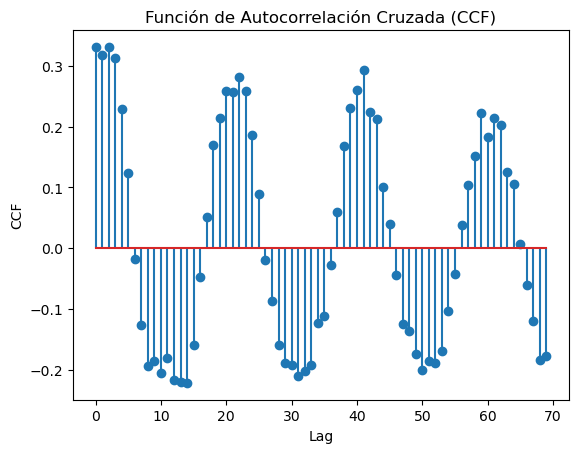

In [179]:
from statsmodels.tsa.stattools import ccf

MediaDestino2_array = train_sarimax['CHU_COPA_AJUST'].values
MediaDestino1_array = train_sarimax['CHU_REC_PROPIOS_AJUST'].values

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Calculo de CCF
lags = 70
cross_corr = ccf(MediaDestino2_array, MediaDestino1_array)[:lags]

# Grafico de CCF
plt.stem(range(lags), cross_corr)  # Eliminar el argumento 'use_line_collection'
plt.title('Función de Autocorrelación Cruzada (CCF)')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

In [184]:
# Ahora armo el modelo SARIMAX con variable endogena
modelo_sarimax = sm.tsa.SARIMAX(train_sarimax['CHU_COPA_AJUST'], order=(5,1,1), seasonal_order=(0,0,0,0), exog=train_sarimax[['CHU_REC_PROPIOS_AJUST', 'CHU_REGALIAS_AJUST']])
resultado_sarimax = modelo_sarimax.fit()
print(resultado_sarimax.summary())



                               SARIMAX Results                                
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                  344
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -5421.287
Date:                Sun, 20 Oct 2024   AIC                          10860.573
Time:                        10:43:12   BIC                          10895.113
Sample:                             0   HQIC                         10874.332
                                - 344                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CHU_REC_PROPIOS_AJUST     0.7613      0.094      8.071      0.000       0.576       0.946
CHU_REGALIAS_AJUST       -0.0091      0.014     -0.647      0.518      -0.037       0.018
ar.L1   

## Ejercicio 7

Detallar una comparación con otros modelos estimados.


## Ejercicio 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

In [108]:
def plotear_residuos(modelo, titulo):
    modelo.resid.plot(figsize=(20,5))
    plt.title(titulo,size=24)
    plt.show()

<h3>CHU_COPA_AJUST</h3>

Tenemos los siguientes modelos construidos:
* resultado_arma_model_copa
* resultado_arma_model_copa_diff
* resultado_arima_model_copa
* resultado_arima_model_copa_diff
* resultado_sarima_model_copa

<h4>Analizamos los residuos de los modelos</h4>

In [103]:
modelos_copa = [ 
        resultado_arma_model_copa ,
        resultado_arma_model_copa_diff ,
        resultado_arima_model_copa ,
        resultado_arima_model_copa_diff ,
        resultado_sarima_model_copa 
]

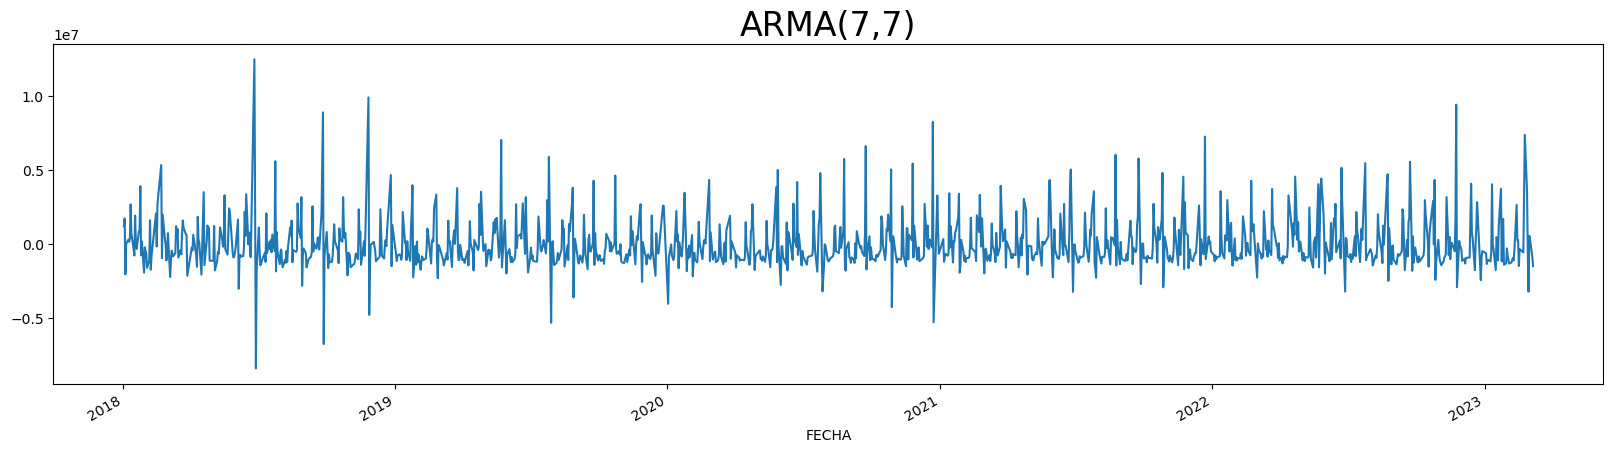

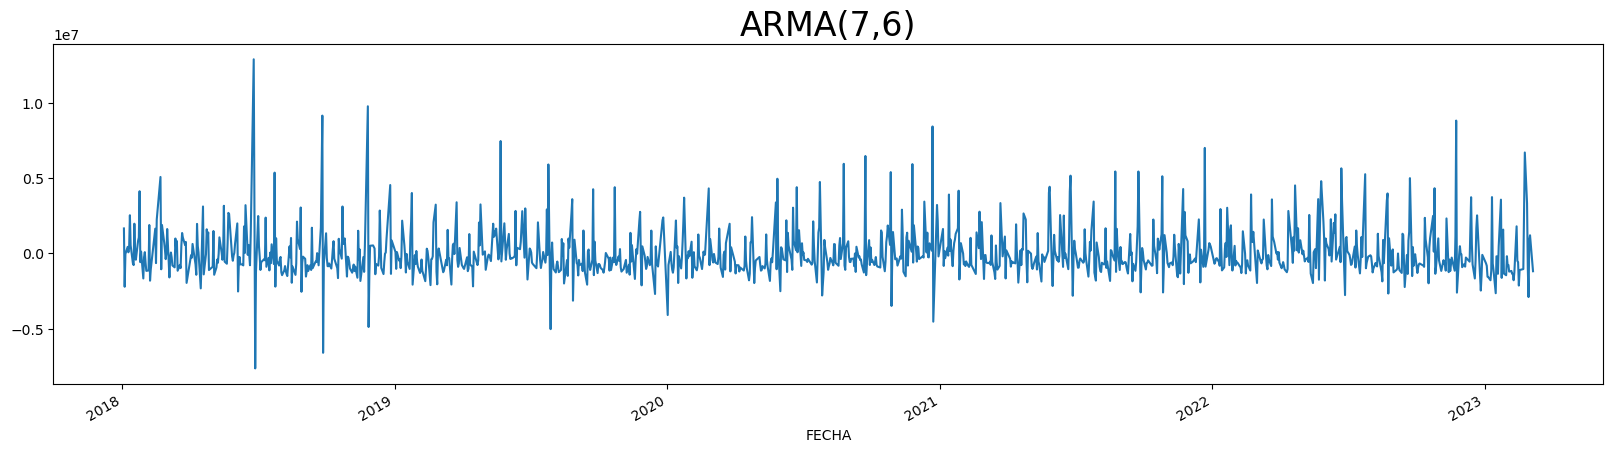

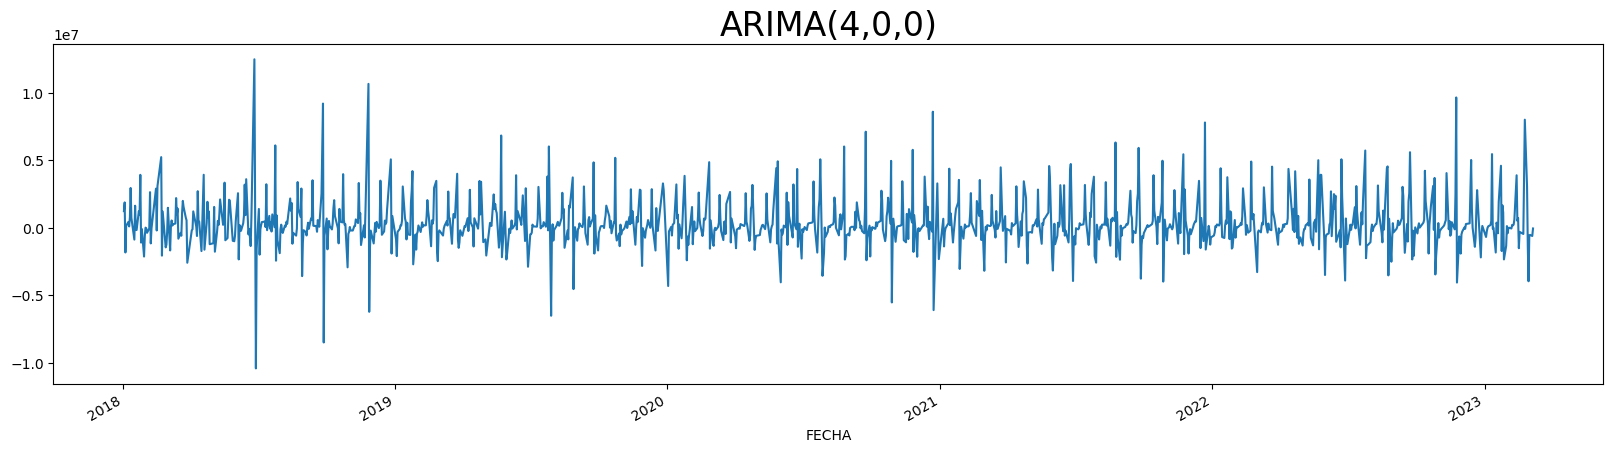

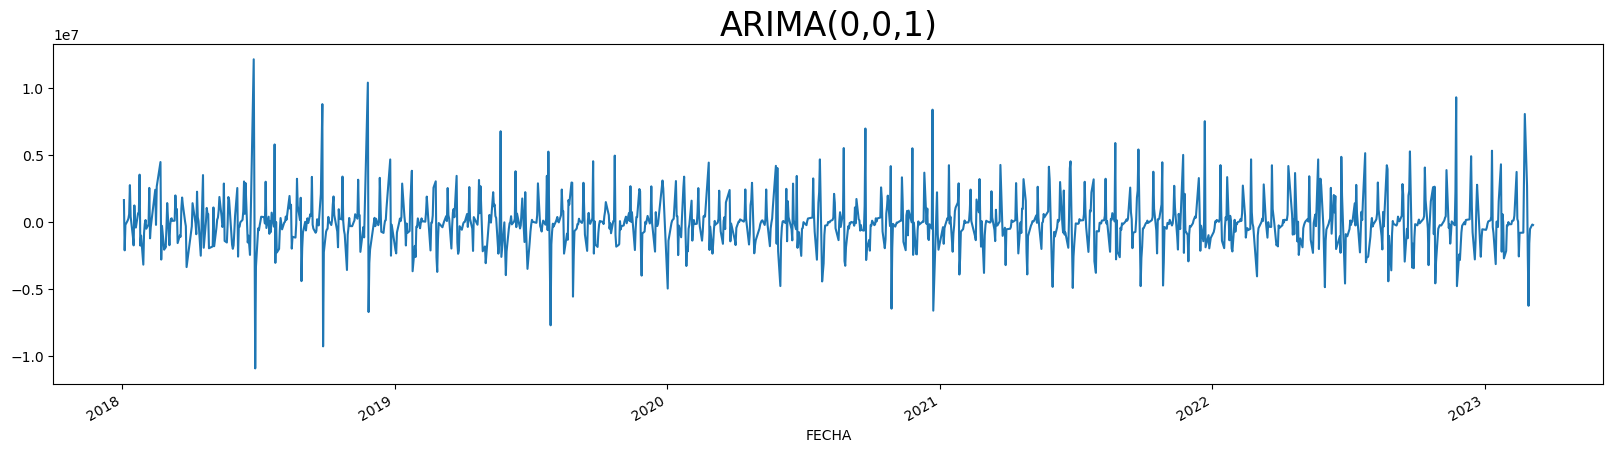

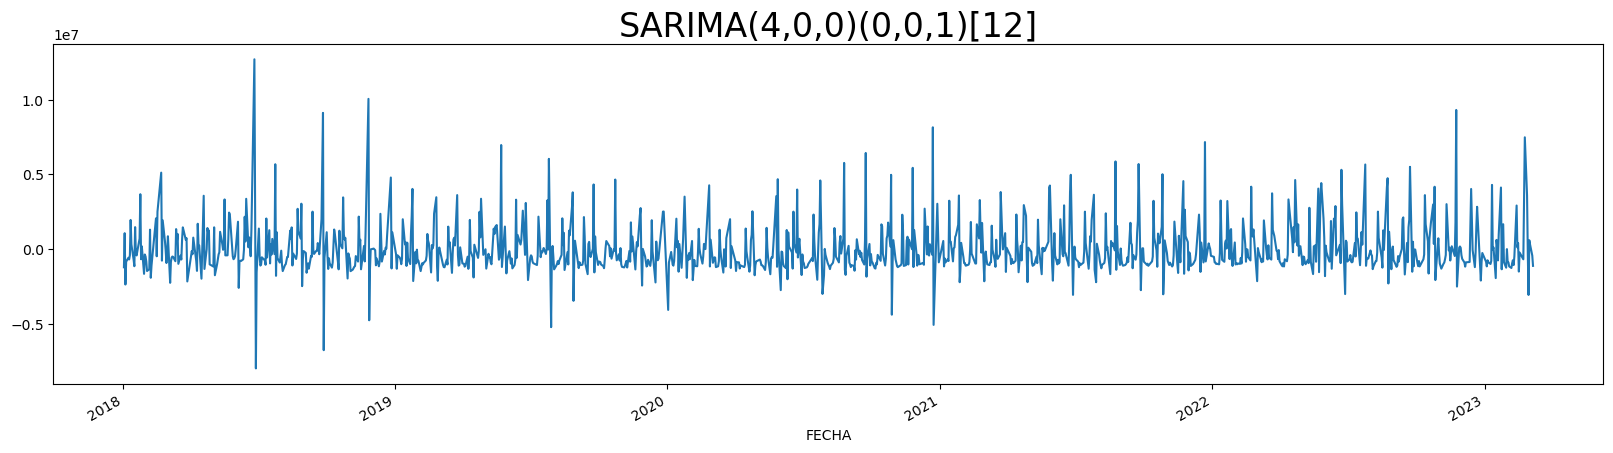

In [109]:
plotear_residuos(modelos_copa[0], "ARMA(7,7)") # Serie original
plotear_residuos(modelos_copa[1], "ARMA(7,6)") # Serie diferencia
plotear_residuos(modelos_copa[2], "ARIMA(4,0,0)") # Serie original
plotear_residuos(modelos_copa[3], "ARIMA(0,0,1)") # Serie diferencia
plotear_residuos(modelos_copa[4], "SARIMA(4,0,0)(0,0,1)[12]") # Serie original

#### Gráficos PAC y PACF de los residuos

In [113]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(model_result, titulo):
    # Obtener los residuos del modelo
    residuals = model_result.resid

    # Crear una figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # ACF en el subplot izquierdo
    plot_acf(residuals, ax=axes[0], lags=40)
    axes[0].set_title(f'{titulo} - Autocorrelation Function (ACF)')

    # PACF en el subplot derecho
    plot_pacf(residuals, ax=axes[1], lags=40)
    axes[1].set_title(f'{titulo} - Partial Autocorrelation Function (PACF)')
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

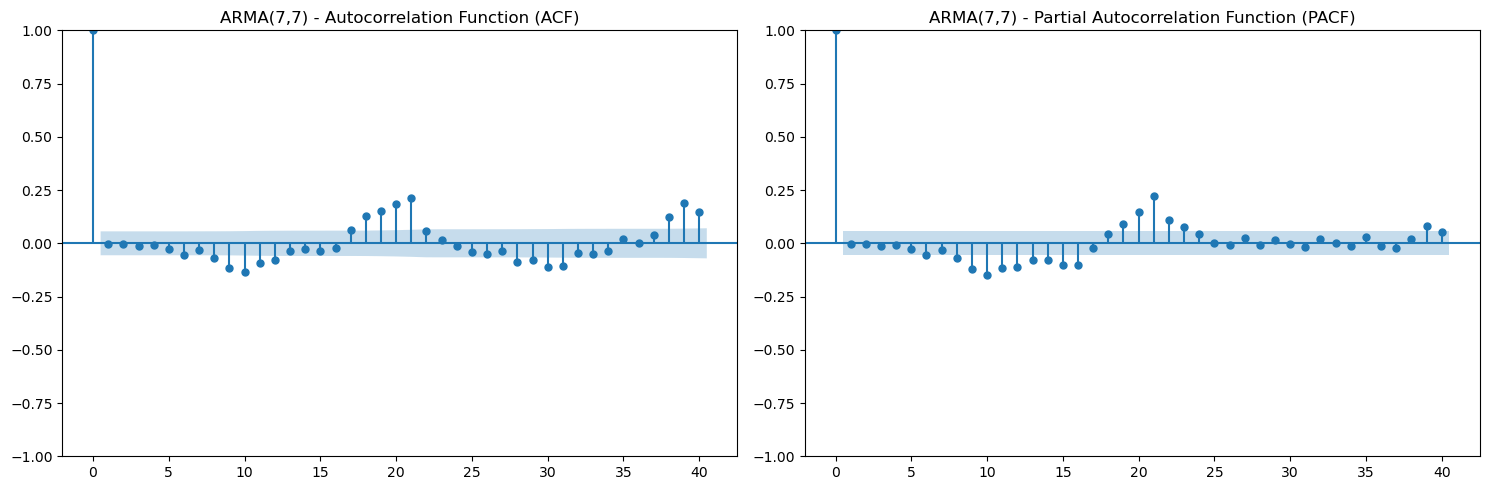

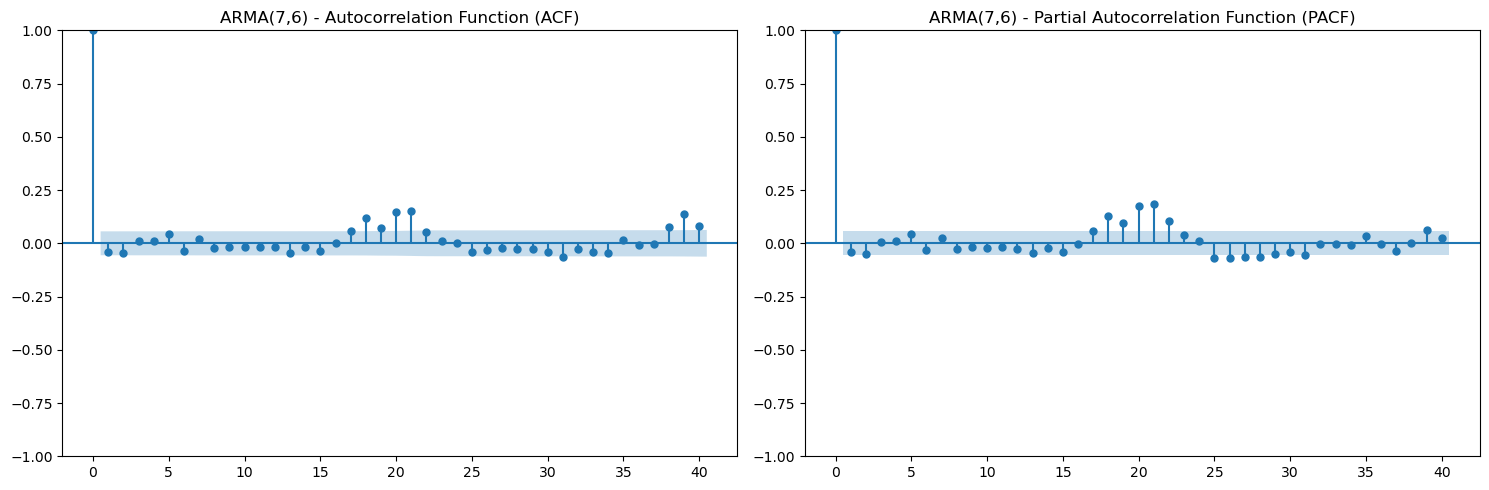

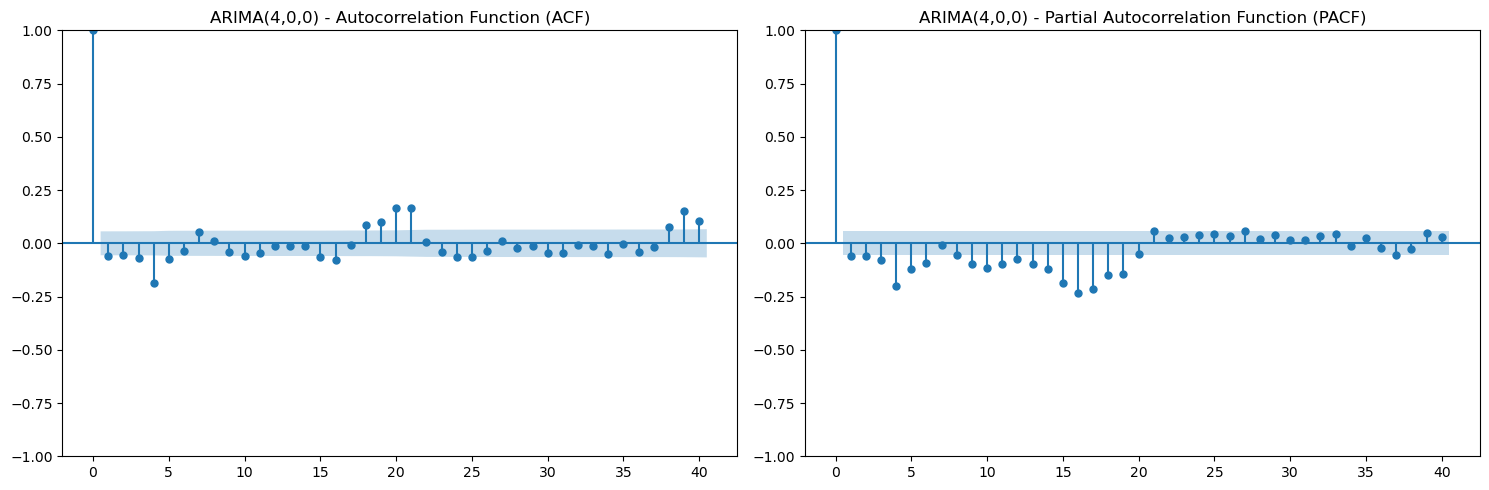

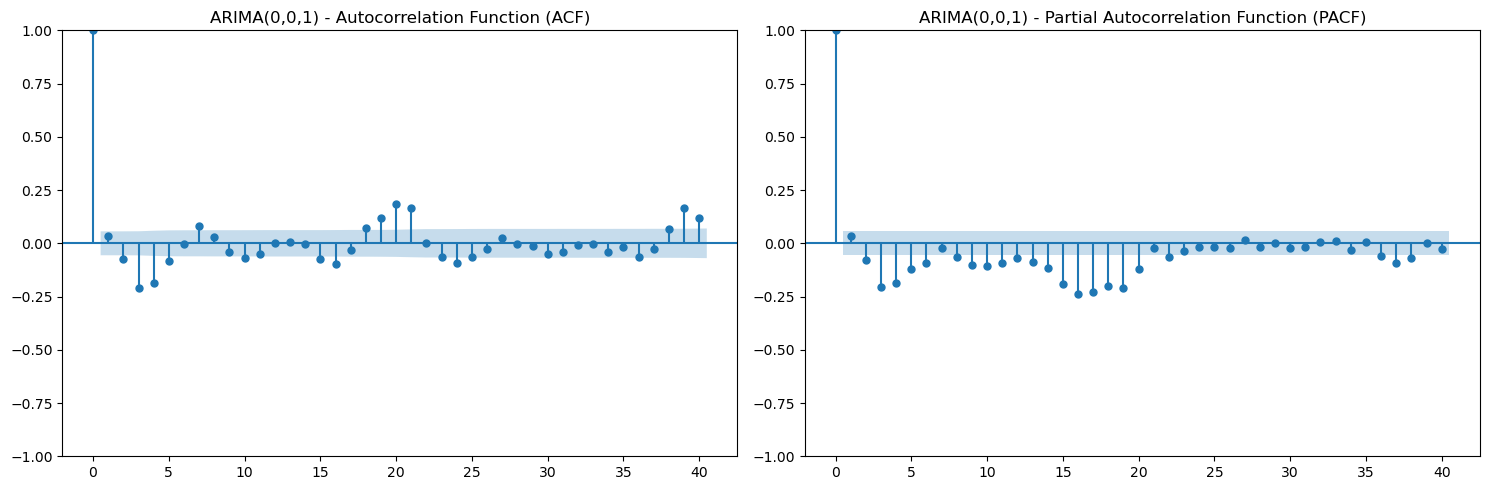

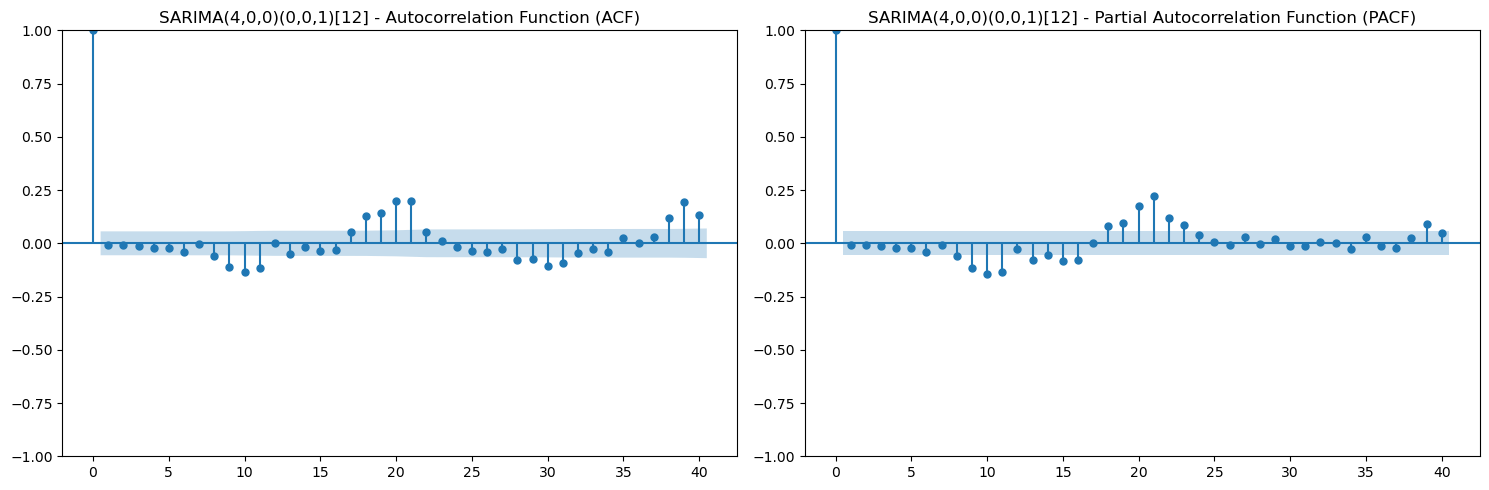

In [114]:
plot_acf_pacf(modelos_copa[0], "ARMA(7,7)") # Serie original
plot_acf_pacf(modelos_copa[1], "ARMA(7,6)") # Serie diferencia
plot_acf_pacf(modelos_copa[2], "ARIMA(4,0,0)") # Serie original
plot_acf_pacf(modelos_copa[3], "ARIMA(0,0,1)") # Serie diferencia
plot_acf_pacf(modelos_copa[4], "SARIMA(4,0,0)(0,0,1)[12]") # Serie original

#### Análisis diagnóstico de los residuos: QQPlot - Normalizacion - Correlograma

In [122]:
def plotear_analisis_diagnostico_residuos(modelo, titulo):
    fig = modelo.plot_diagnostics(figsize=(12, 10))
    
    # Agregar un título general a la figura
    fig.suptitle(titulo, size=18, y=1.02)  # y=1.02 ajusta la posición vertical del título
    
    plt.tight_layout()  # Asegura que los subgráficos no se solapen
    plt.show()


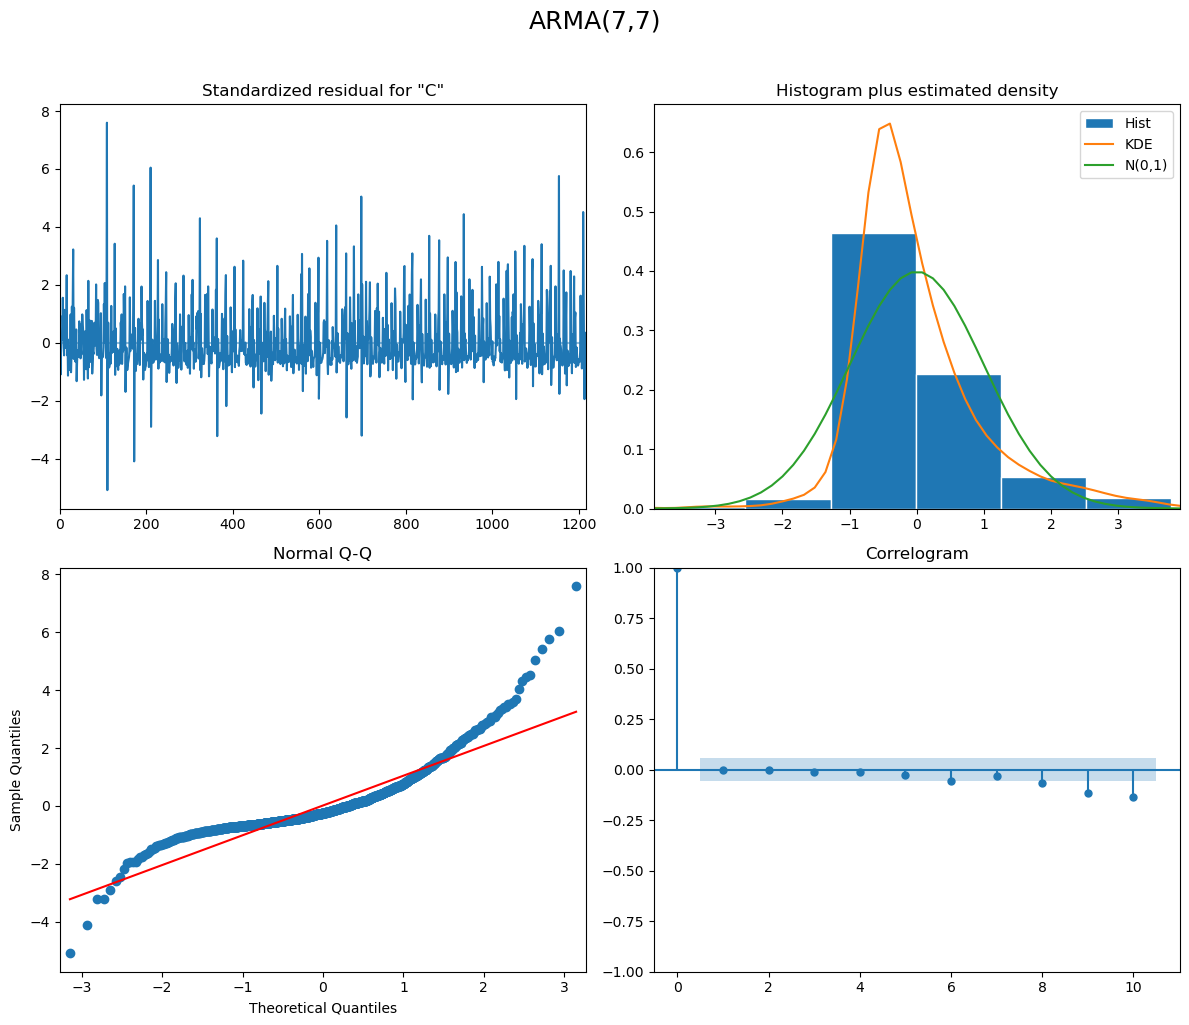

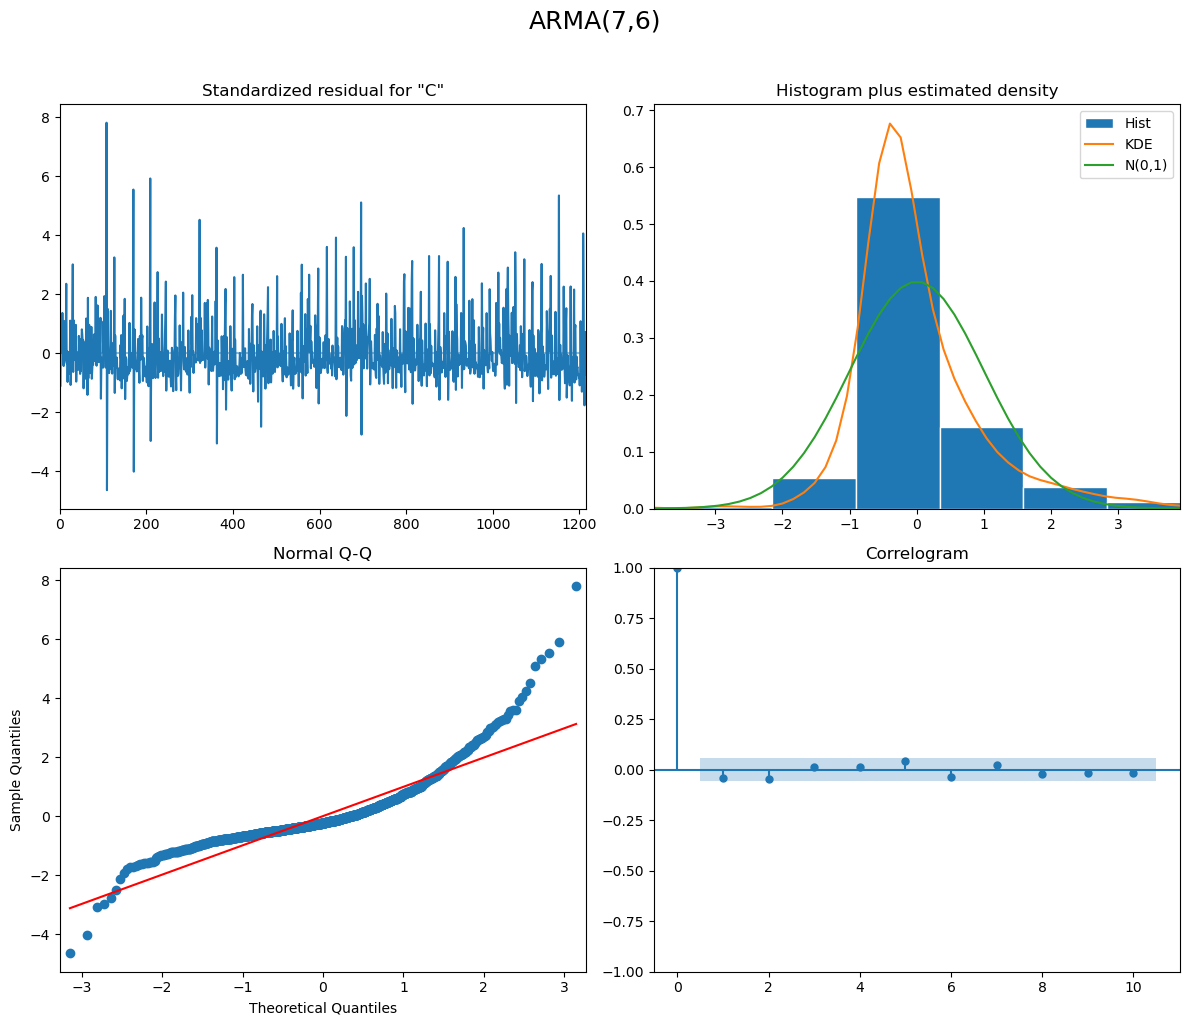

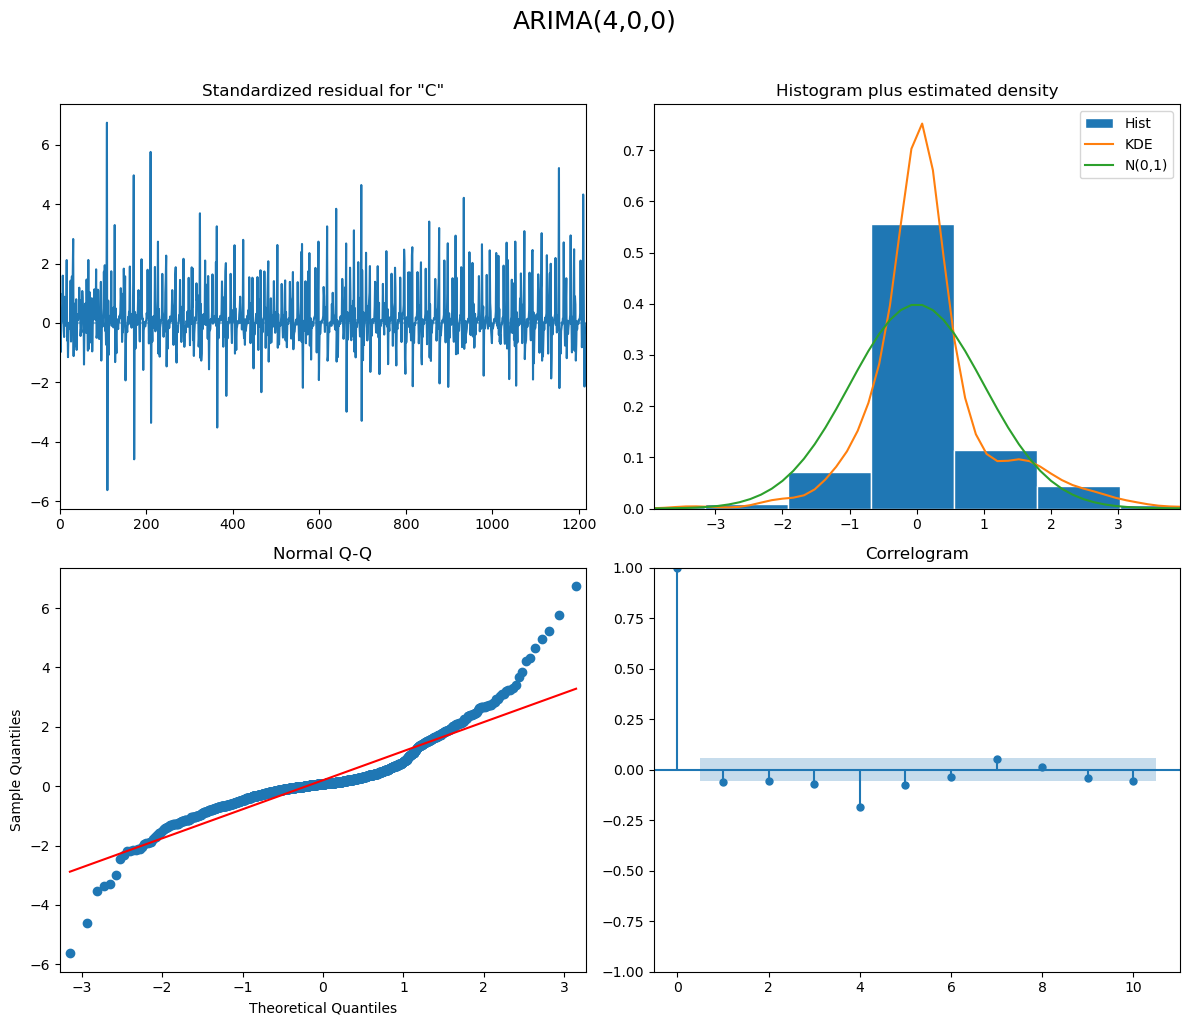

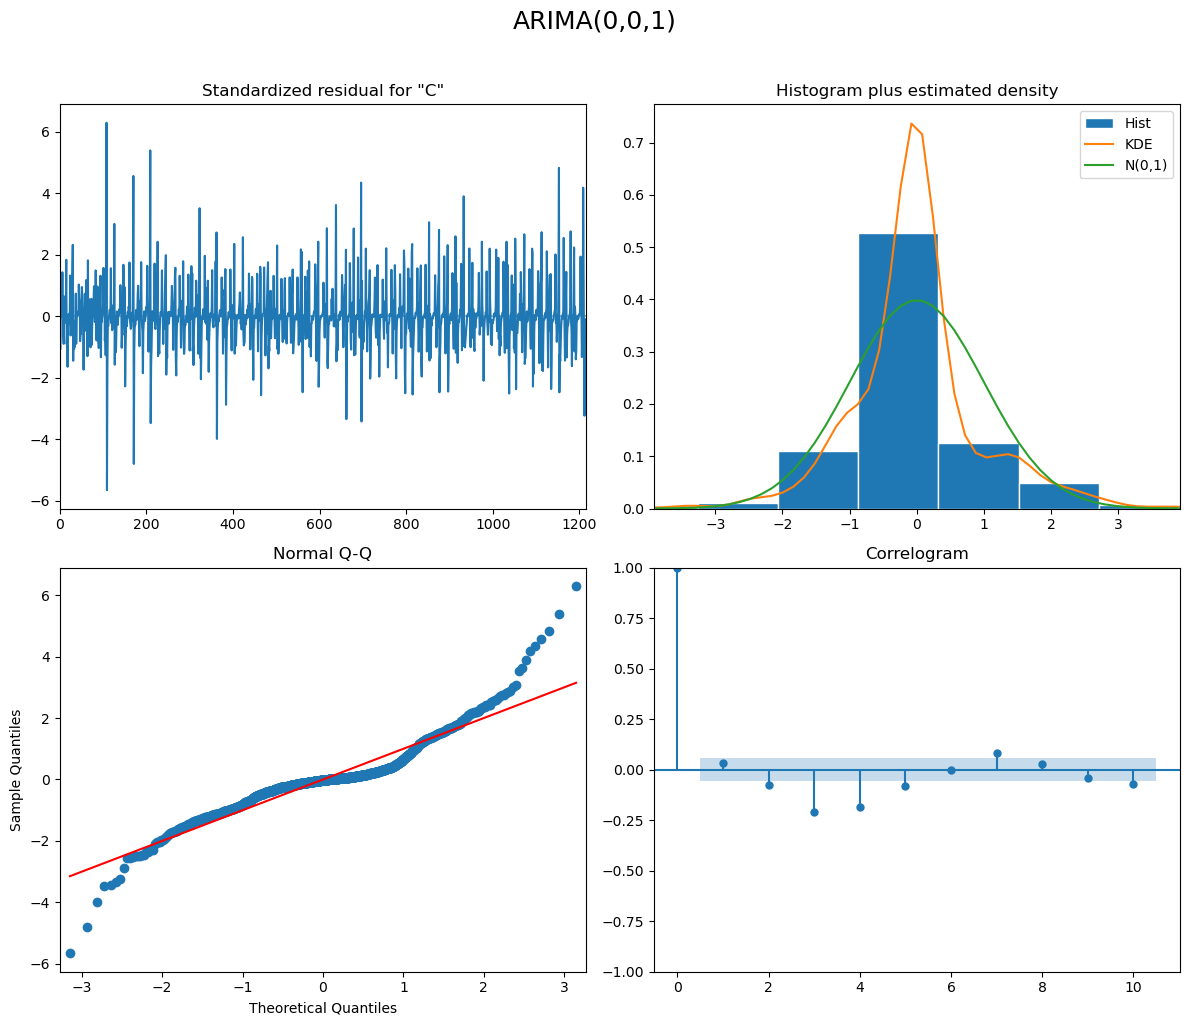

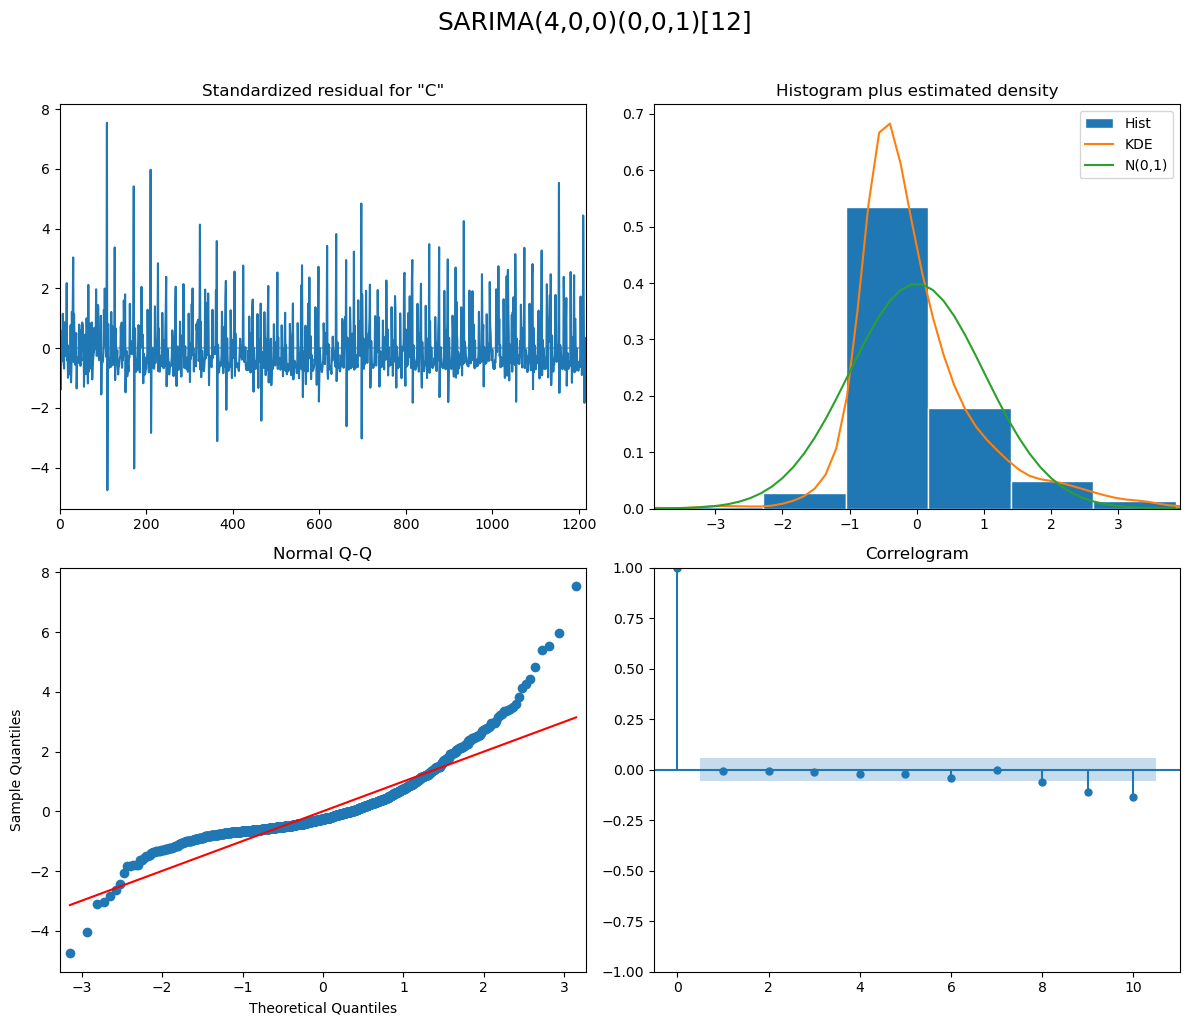

In [124]:
plotear_analisis_diagnostico_residuos(modelos_copa[0], "ARMA(7,7)") # Serie original
plotear_analisis_diagnostico_residuos(modelos_copa[1], "ARMA(7,6)") # Serie diferencia
plotear_analisis_diagnostico_residuos(modelos_copa[2], "ARIMA(4,0,0)") # Serie original
plotear_analisis_diagnostico_residuos(modelos_copa[3], "ARIMA(0,0,1)") # Serie diferencia
plotear_analisis_diagnostico_residuos(modelos_copa[4], "SARIMA(4,0,0)(0,0,1)[12]") # Serie original

#### Incorrelación de los residuos

In [136]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plotear_incorrelacion(modelo_1, modelo_2, titulo_1, titulo_2):
    # Calcular los valores de Ljung-Box para los residuos del modelo
    Incorr_residuos_modelo_1 = sm.stats.acorr_ljungbox(modelo_1.resid, lags=30, return_df=True)
    

    # Crear una figura con dos subplots (2 gráficos por fila)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 fila, 2 columnas

    # Gráfico de P-valores
    axes[0].plot(Incorr_residuos_modelo_1['lb_pvalue'], marker='o', markersize=10, linestyle='--', linewidth=1)
    axes[0].set_title(f"Incorrelación - P-valores del modelo {titulo_1}")
    axes[0].set_ylabel("P-valores")
    axes[0].set_xlabel("Lags")
    
    if( modelo_2 is not None ):
        Incorr_residuos_modelo_2 = sm.stats.acorr_ljungbox(modelo_2.resid, lags=30, return_df=True)
        # Gráfico de los estadísticos Ljung-Box
        axes[1].plot(Incorr_residuos_modelo_2['lb_stat'], marker='o', markersize=10, linestyle='--', linewidth=1, color='r')
        axes[1].set_title(f"Incorrelación - Estadísticos Ljung-Box del modelo {titulo_2}")
        axes[1].set_ylabel("Estadísticos")
        axes[1].set_xlabel("Lags")

    # Título general para los dos gráficos
    # fig.suptitle(titulo, size=18, y=1.02)

    # Ajustar el layout para evitar solapamientos
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# plotear_incorrelacion(resultado_sarima_model_copa, "Modelo SARIMA")


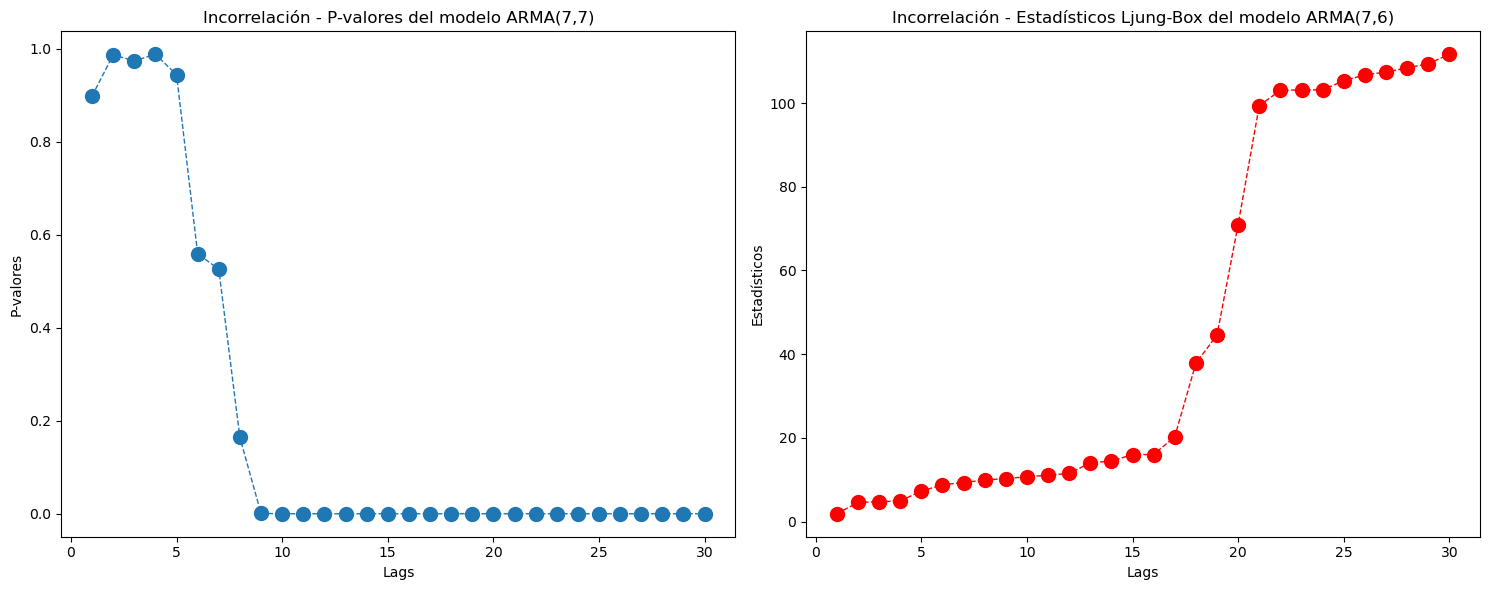

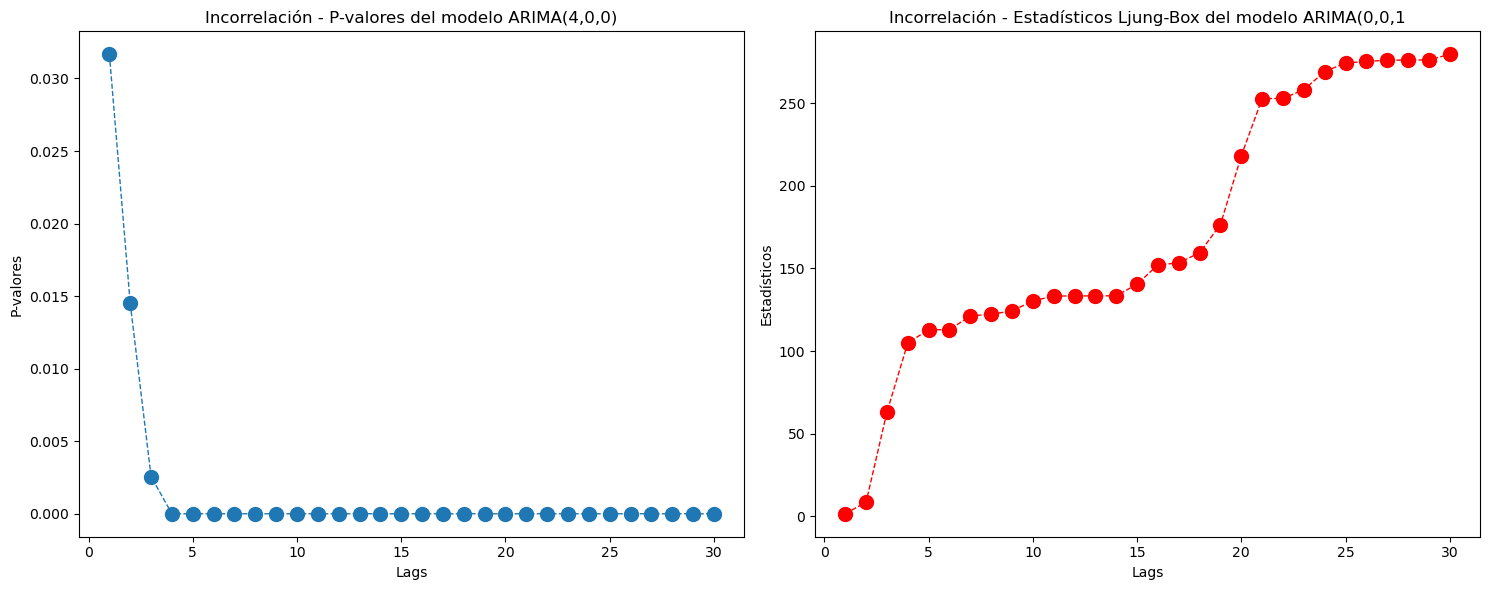

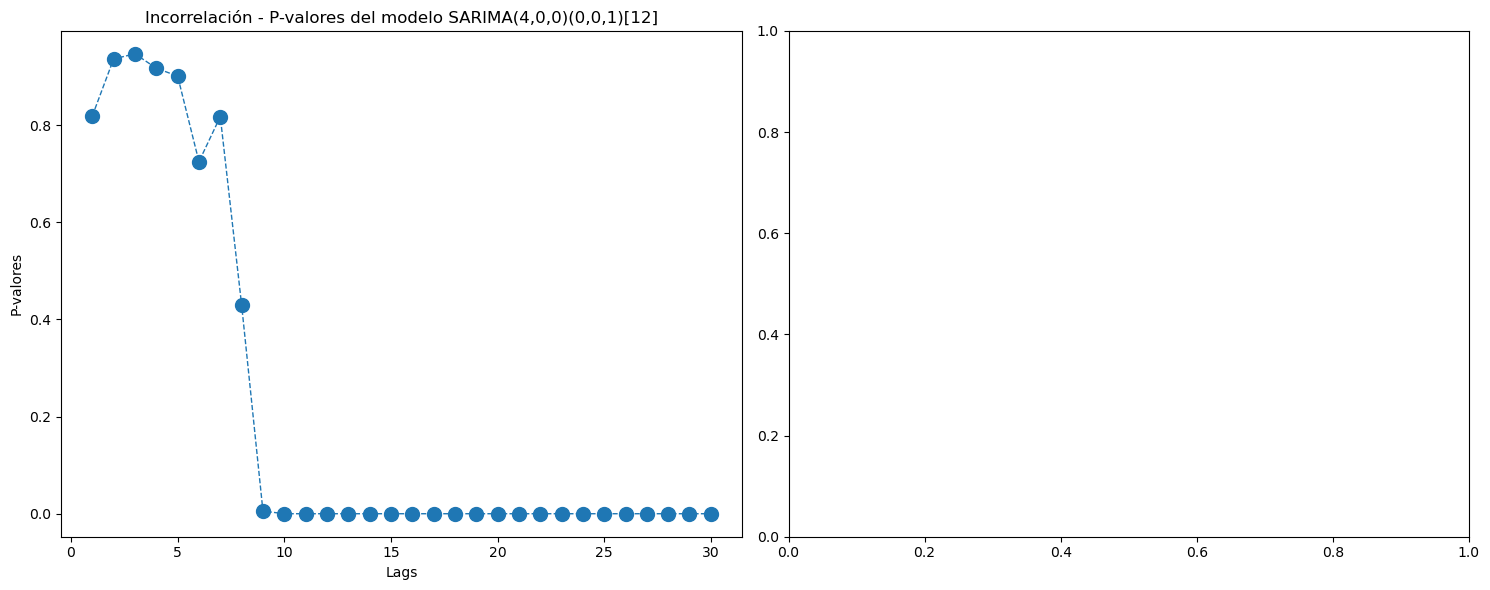

In [137]:
plotear_incorrelacion(modelos_copa[0], modelos_copa[1], "ARMA(7,7)", "ARMA(7,6)") # Serie original y Serie diferencia
plotear_incorrelacion(modelos_copa[2], modelos_copa[3], "ARIMA(4,0,0)", "ARIMA(0,0,1")  # Serie original y Serie diferencia
plotear_incorrelacion(modelos_copa[4], None, "SARIMA(4,0,0)(0,0,1)[12]", "") # Serie original

In [138]:
def plotear_incorrelacion(model_result, titulo):
    
    Incorr_residuos_modelo=sm.stats.acorr_ljungbox(model_result.resid, lags=30)

    
    plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
    plt.title(f"Grafico de incorrelacion de los residuos del modelo {titulo}")
    plt.ylabel("P-valores")

    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

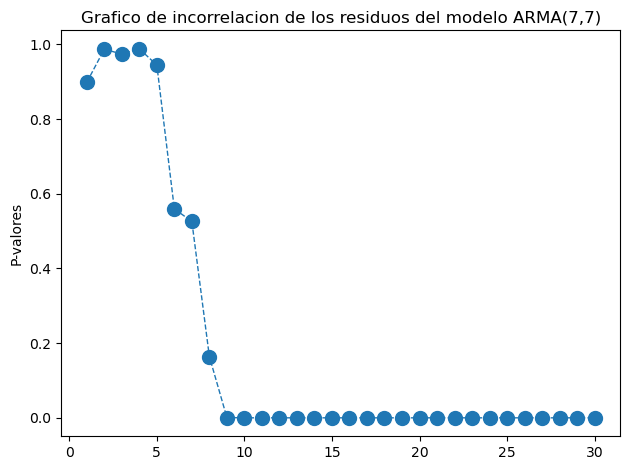

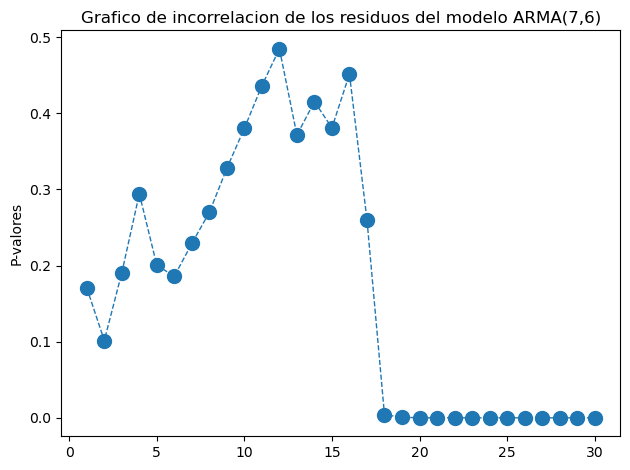

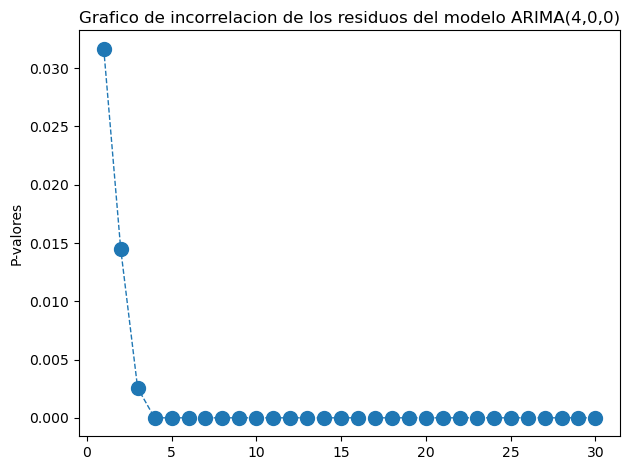

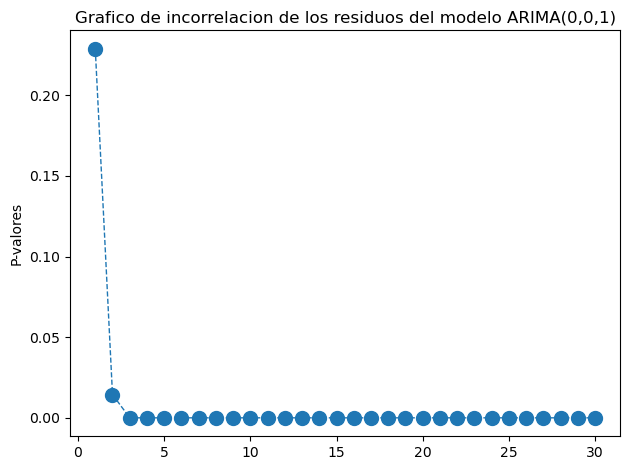

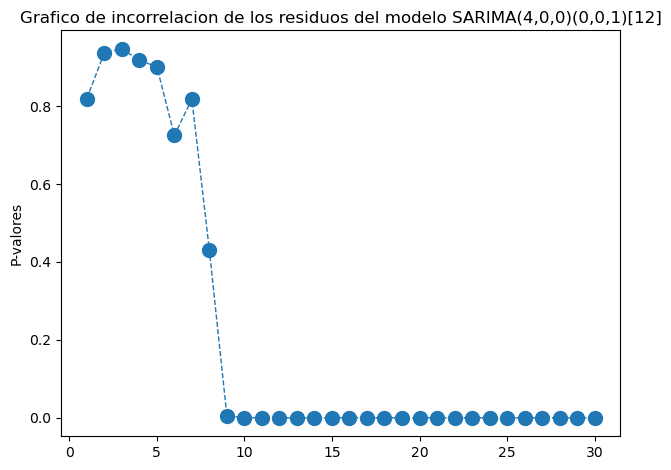

In [139]:
plotear_incorrelacion(modelos_copa[0], "ARMA(7,7)") # Serie original
plotear_incorrelacion(modelos_copa[1], "ARMA(7,6)") # Serie diferencia
plotear_incorrelacion(modelos_copa[2], "ARIMA(4,0,0)") # Serie original
plotear_incorrelacion(modelos_copa[3], "ARIMA(0,0,1)") # Serie diferencia
plotear_incorrelacion(modelos_copa[4], "SARIMA(4,0,0)(0,0,1)[12]") # Serie original

*Vemos que muchos p-valores están por debajo del 0.05 entonces hay correlación entre residuos.*

#### Test de Box-Pierce para analizar residuos

In [141]:
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2

def test_de_box_pierce(modelo, titulo):
    print("---------------------------------------------------------------------------------------------")
    print(f"Test de box pierce para {titulo}")
    
    # Test Box-Pierce
    lags = 10

    acf_values = acf(modelo.resid, nlags=lags, fft=False)
    
    # Calculamos el estadistico de prueba Q de Box-Pierce
    n = len(modelo.resid)
    Q = n * np.sum(np.square(acf_values[1:lags+1]))
    p_value = 1 - chi2.cdf(Q, df=lags)
    
    print(f'Estadística de prueba (Q): {Q:.4f}')
    print(f'Valor p: {p_value:.4f}')
    alpha = 0.05
    if p_value < alpha:
        print("Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.")
    else:
        print("No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.")
    print("---------------------------------------------------------------------------------------------")
    

In [142]:
test_de_box_pierce(modelos_copa[0], "ARMA(7,7)") # Serie original
test_de_box_pierce(modelos_copa[1], "ARMA(7,6)") # Serie diferencia
test_de_box_pierce(modelos_copa[2], "ARIMA(4,0,0)") # Serie original
test_de_box_pierce(modelos_copa[3], "ARIMA(0,0,1)") # Serie diferencia
test_de_box_pierce(modelos_copa[4], "SARIMA(4,0,0)(0,0,1)[12]") # Serie original

---------------------------------------------------------------------------------------------
Test de box pierce para ARMA(7,7)
Estadística de prueba (Q): 50.9534
Valor p: 0.0000
Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
Test de box pierce para ARMA(7,6)
Estadística de prueba (Q): 10.6576
Valor p: 0.3848
No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.
---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
Test de box pierce para ARIMA(4,0,0)
Estadística de prueba (Q): 74.2218
Valor p: 0.0000
Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.
-----------------------

## Ejercicio 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

*El único modelo cuyos residuos estan incorrelacionados es el ARIMA(7,6) con la serie diferenciada una vez. A continuación vemos la predicción.*

In [146]:
dataframes_train_diff1 = [ train_copa_diff1, train_recursos_diff1, train_regalias_diff1 ]
dataframes_test_diff1 = [ test_copa_diff1, test_recursos_diff1, test_regalias_diff1 ]

FECHA
2018-01-03    1.644434e+06
2018-01-04   -2.482345e+06
2018-01-05    3.132795e+05
2018-01-08    1.698451e+05
2018-01-09    2.383883e+05
                  ...     
2023-03-01   -5.611518e+06
2023-03-02   -4.576929e+04
2023-03-03   -1.197186e+05
2023-03-06   -5.277188e+04
2023-03-07   -1.680104e+05
Name: CHU_COPA_AJUST, Length: 1217, dtype: float64

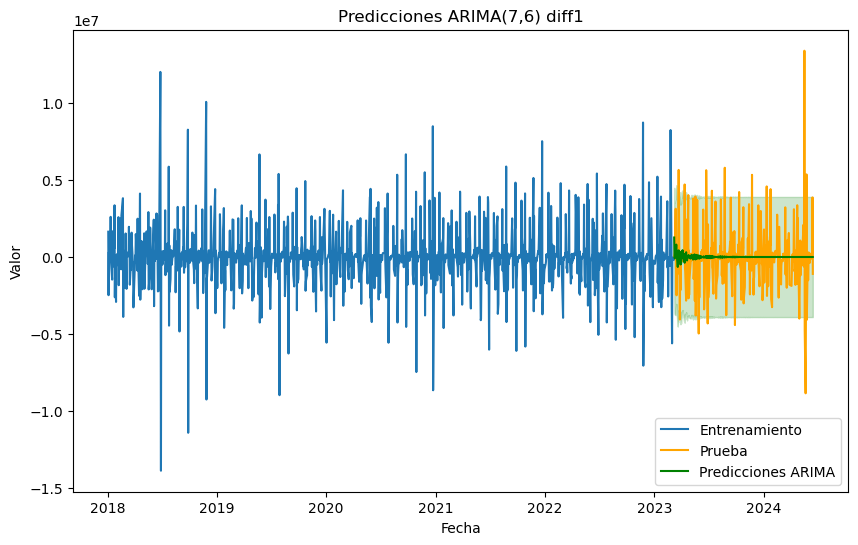

In [152]:
predicciones_arma = modelos_copa[1].get_forecast(steps=len(dataframes_test_diff1[0]))
pred_train3 = predicciones_arma.predicted_mean
conf_int = predicciones_arma.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(dataframes_train_diff1[0].index, dataframes_train_diff1[0], label='Entrenamiento')
plt.plot(dataframes_test_diff1[0].index, dataframes_test_diff1[0], label='Prueba', color='orange')
plt.plot(dataframes_test_diff1[0].index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(dataframes_test_diff1[0].index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA(7,6) diff1')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [153]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')
    
evaluar_metricas(dataframes_test_diff1[0], predicciones_arma.predicted_mean)

MSE: 4212041046394.411
MAE: 1316508.935279116
RMSE: 2052325.7651733584
MAPE: nan


##  Ejercicio 10
Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.


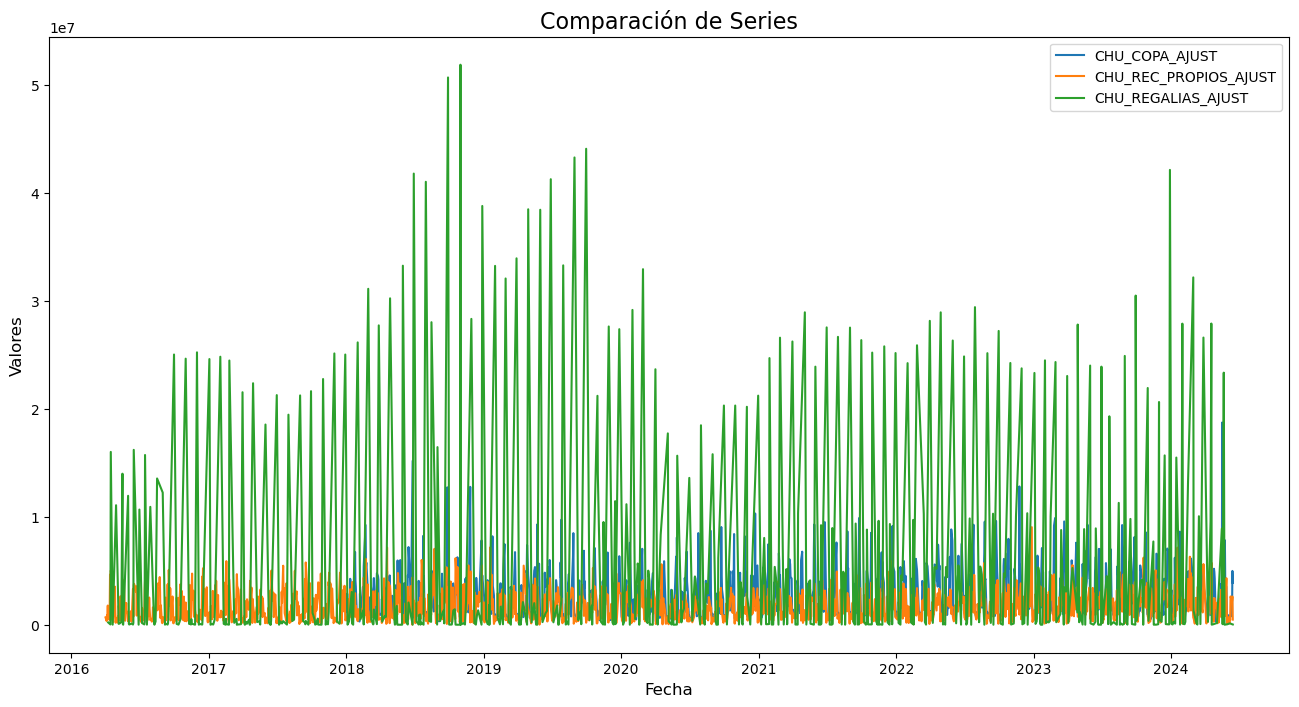

In [190]:
import matplotlib.pyplot as plt

# Crear una figura y ejes para los gráficos
fig, ax = plt.subplots(figsize=(16, 8))

# Graficar los tres dataframes con una paleta de colores personalizada
ax.plot(dataframes[0], label=dataframes[0].name, color='#1f77b4')  # Azul
ax.plot(dataframes[1], label=dataframes[1].name, color='#ff7f0e')  # Naranja
ax.plot(dataframes[2], label=dataframes[2].name, color='#2ca02c')  # Verde

# Añadir leyenda arriba a la derecha
ax.legend(loc='upper right')

# Añadir título y etiquetas de los ejes si es necesario
plt.title('Comparación de Series', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valores', fontsize=12)

# Mostrar el gráfico
plt.show()


In [188]:
# Separacion Train/Test

# Variable que guarda el porcentaje de train
split = .9

# Seleccion de train
train_var = df_merged.iloc[:round(len(df_merged)*split)]

# Seleccionamos de test
test_var = df_merged.iloc[round(len(df_merged)*split):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train_var.shape,"\n\n", test_var.shape)

(387, 3) 

 (43, 3)


##### Criterio de Granger
La hipótesis nula supone que el pasado de una variable no proporciona información adicional para predecir la otra variable más allá de lo que ya se puede predecir utilizando solo su propio pasado.
- H0: La serie temporal X no causa grangerianamente la serie temporal Y.  
- H1: La serie temporal X causa grangerianamente la serie temporal Y.  

In [191]:
from statsmodels.tsa.stattools import grangercausalitytests

In [192]:
# P-valores menores al nivel de significancia (0.05) implica que la hipotesis nula (X no causa Y) puede rechazarse.
# testgr: Es el tipo de prueba que se utilizará para evaluar la causalidad de Granger. Por defecto, se utiliza 'ssr_chi2test', que es una prueba basada en chi-cuadrado,

def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):


    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# se agrega '_x' al final de los nombres de las columnas para indicar que son las variables "causantes" y '_y' al final de los nombres de las filas para indicar que son las variables "afectadas".

In [193]:
testgr = 'ssr_chi2test'
grangers_causation_matrix(train_var, variables = train_var.columns, maxlag=20)

CHU_COPA_AJUST_x  CHU_REC_PROPIOS_AJUST_x  \
CHU_COPA_AJUST_y             1.000000e+00                 0.094448   
CHU_REC_PROPIOS_AJUST_y      8.969867e-02                 1.000000   
CHU_REGALIAS_AJUST_y         3.320573e-11                 0.004739   

                         CHU_REGALIAS_AJUST_x  
CHU_COPA_AJUST_y                 1.015801e-12  
CHU_REC_PROPIOS_AJUST_y          4.160159e-06  
CHU_REGALIAS_AJUST_y             1.000000e+00

#### Resumen de causalidades significativas:
* CHU_COPA_AJUST_y aporta información a CHU_REGALIAS_AJUST_x.
* CHU_REC_PROPIOS_AJUST_y aporta información a CHU_REGALIAS_AJUST_x.
* CHU_REGALIAS_AJUST_y aporta información a CHU_COPA_AJUST_x y CHU_REC_PROPIOS_AJUST_x.

In [194]:
from statsmodels.tsa.api import VAR

model = VAR(train_var)

A continuación se utiliza el método select_order del modelo VAR (model) para seleccionar el orden adecuado del modelo VAR basado en criterios estadísticos. El parámetro maxlags se establece en 70, lo que significa que el código considerará modelos VAR con hasta 70 rezagos.
- AIC (Akaike Information Criterion)  
- BIC (Bayesian Information Criterion)  
- FPE (Final Prediction Error)  
- HQIC (Hannan-Quinn Information Criterion)  

In [195]:
x = model.select_order(maxlags=20)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [196]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Oct, 2024
Time:                     11:32:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    88.9547
Nobs:                     383.000    HQIC:                   88.7122
Log likelihood:          -18549.2    FPE:                2.87061e+38
AIC:                      88.5527    Det(Omega_mle):     2.59708e+38
--------------------------------------------------------------------
Results for equation CHU_COPA_AJUST
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                      2941751.908567    457276.810809            6.433           0.000
L1.CHU_COPA_AJUST                0.042821         0.057279            0.748           0.455
L1.CHU_

Predicción

In [197]:
# Funcion que recibe listas con las predicciones e intervalos de confianza de las 3 series y devuelve un
# dataframe para la serie indicada por la variable indice
def serializar(predicciones_, test_, indice, futuro_, intervalos=True):

    serie = {
        "FECHA": test_.index[:futuro_],
        "serie"+str(indice): predicciones_[0][:,indice-1].tolist(),
        "serie"+str(indice)+"_inf": predicciones_[1][:,indice-1].tolist(),
        "serie"+str(indice)+"_sup": predicciones_[2][:,indice-1].tolist()}
    serie = pd.DataFrame(serie, columns=["FECHA", "serie"+str(indice),
                                         "serie"+str(indice)+"_inf", "serie"+str(indice)+"_sup"])
    serie.set_index("FECHA", inplace=True)
    if (intervalos==False):
        serie.loc[serie["serie"+str(indice)+"_inf"] < 0, "serie"+str(indice)+"_inf"] = 0
        serie.loc[serie["serie"+str(indice)+"_sup"] < 0, "serie"+str(indice)+"_sup"] = 0
    return serie

In [217]:
import pandas as pd

def serializar(predicciones_, test_, indice, futuro_, intervalos=True):
    # Verificar si predicciones_ tiene la longitud esperada
    predicciones = predicciones_[0]  # Predicciones
    inf_intervalo = predicciones_[1]  # Intervalos inferiores
    sup_intervalo = predicciones_[2]  # Intervalos superiores

    # Asegúrate de que los arrays tienen la longitud correcta
    print("Longitud de predicciones:", predicciones.shape[0])
    print("Longitud de inf_intervalo:", inf_intervalo.shape[0])
    print("Longitud de sup_intervalo:", sup_intervalo.shape[0])
    
    # Asegúrate de que las longitudes coincidan con el número de pasos de predicción
    if len(test_.index[:futuro_]) != predicciones.shape[0]:
        raise ValueError("La longitud de las predicciones no coincide con el número de pasos a predecir.")

    # Crear un diccionario para la nueva serie
    serie = {
        "FECHA": test_.index[:futuro_],  # Asegúrate de que esto coincida con el tamaño de predicciones
        "serie" + str(indice): predicciones[:, indice - 1].tolist(),
        "serie" + str(indice) + "_inf": inf_intervalo[:, indice - 1].tolist(),
        "serie" + str(indice) + "_sup": sup_intervalo[:, indice - 1].tolist()
    }

    # Convertir el diccionario en un DataFrame
    serie = pd.DataFrame(serie, columns=["FECHA", "serie" + str(indice),
                                         "serie" + str(indice) + "_inf", "serie" + str(indice) + "_sup"])
    
    # Establecer FECHA como índice
    serie.set_index("FECHA", inplace=True)
    
    # Ajustar valores de intervalos a 0 si son negativos, si es necesario
    if not intervalos:
        serie.loc[serie["serie" + str(indice) + "_inf"] < 0, "serie" + str(indice) + "_inf"] = 0
        serie.loc[serie["serie" + str(indice) + "_sup"] < 0, "serie" + str(indice) + "_sup"] = 0
        
    return serie


In [198]:
def graficar_pred(serie_test, serie_pred, titulo="Valores Originales vs Predicciones",
                  xlabel="Fecha", ylabel="Valor", intervalos=True):
    # serie_test:
    # serie_pred:

    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.iloc[:,0].plot(label="Predicciones")
    if (intervalos==True):
        serie_pred.iloc[:,2].plot(label="Intervalo de Confianza Superior")
        serie_pred.iloc[:,1].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.5', dashes=(5,2,1,2))

Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15
Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15
Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15


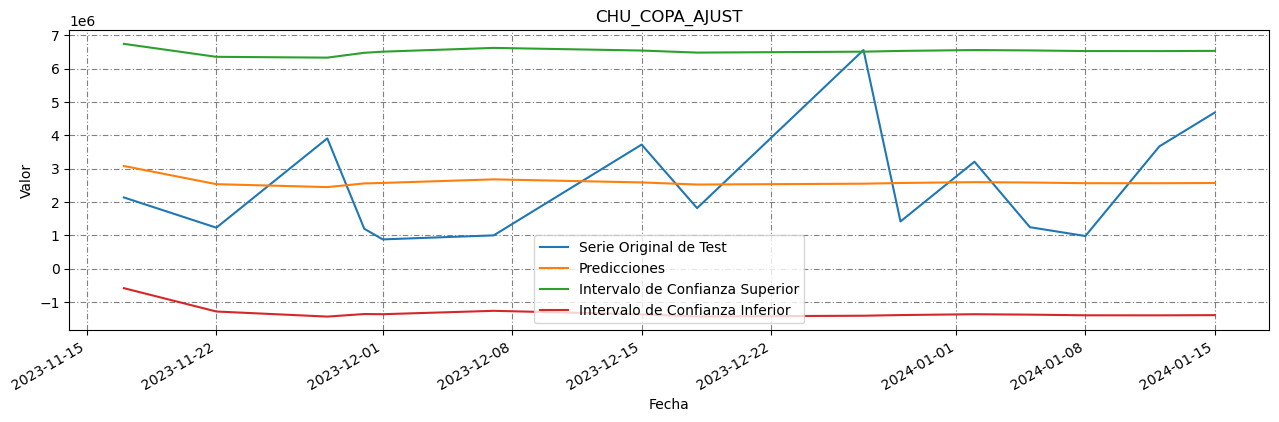

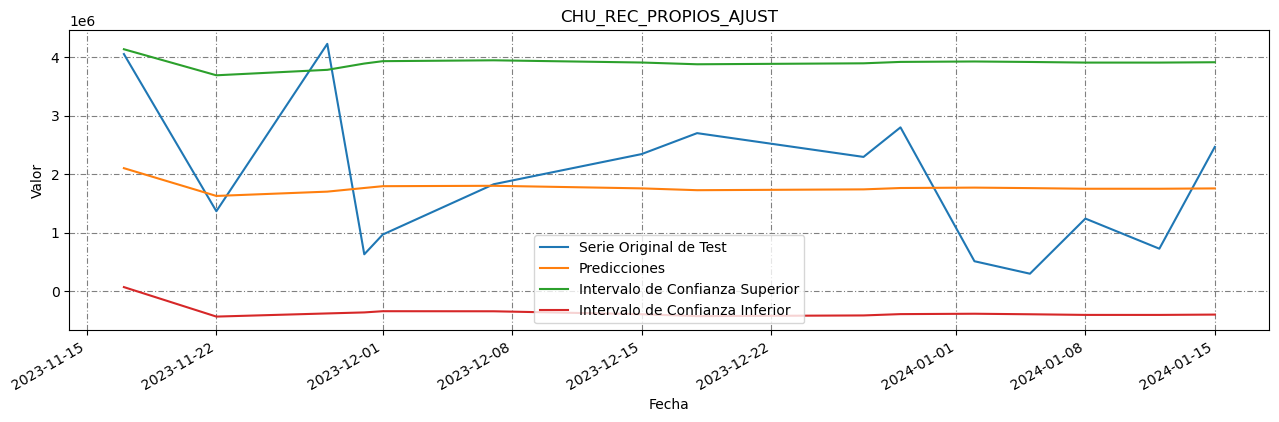

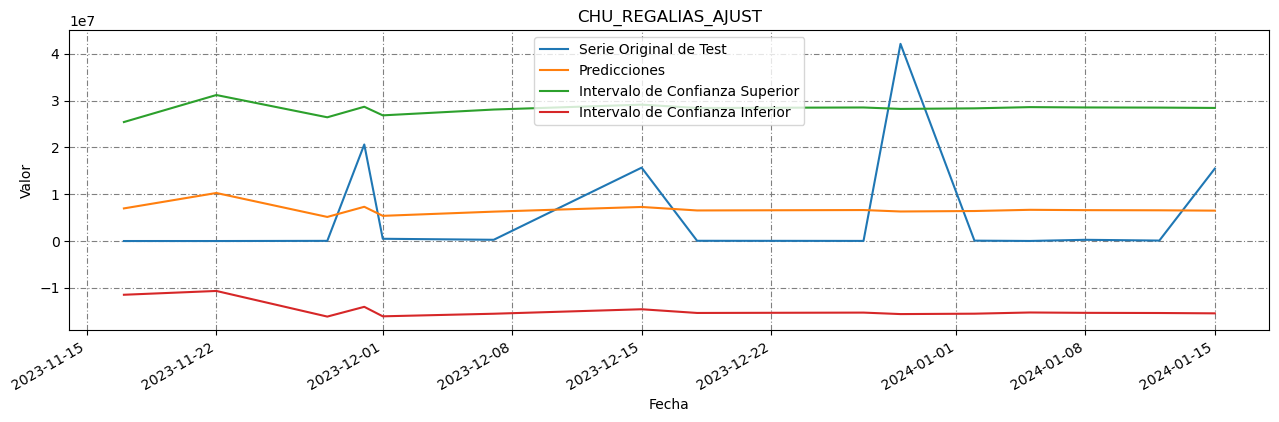

In [221]:
# Con la variable futuro se indican cuantas unidades en tiempo
# hacia adelante se quieren predecir
futuro = 15
lag_orden = 18

predicciones = model_fitted.forecast_interval(train_var.values[-lag_orden:], steps=futuro)

df = list()
for i in range(1, 4):  # Cambié de [1, 2, 3] a range(1, 4) para mayor claridad
    df.append(serializar(predicciones, test_var, i, futuro))

serieVAR = ['CHU_COPA_AJUST', 'CHU_REC_PROPIOS_AJUST', 'CHU_REGALIAS_AJUST']

for i, serie in enumerate(serieVAR):
    graficar_pred(test_var[serie][:futuro], df[i], titulo=serie)


In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

In [223]:
def test_residuos(residuos):


    # Test de Jarque Bera
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    jarquebera = jarque_bera(residuos)
    print('Jarque-Bera')
    print(f'p-valor: {jarquebera[1]}\n')

    # Test de Shapiro Wilks
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    shapir = shapiro(residuos)
    print('Shapiro')
    print(f'p-valor: {shapir[1]}\n')

In [224]:
def evaluar_residuos(residuos):
    residuos.plot(title='Residuos', figsize=(12, 3))
    plt.axhline(0, linestyle='--', color='k')
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].set_title('Residuos KDE')
    ax[1].set_title('Q-Q Plot')
    residuos.plot(kind='kde', ax=ax[0])
    probplot(residuos, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(residuos)
    acf.set_size_inches(12,3)
    plt.show()
    print('Descriptivo Residuos\n')
    print(f'{residuos.describe()}\n\n')
    print('Test sobre los Residuos\n')
    test_residuos(residuos)

CHU_COPA_AJUST
-----------------------------
MSE: 2787791487896.3013
MAE: 1479987.748623582
RMSE: 1669668.077162734
MAPE: 0.8224
Evaluacion de residuos de Serie 


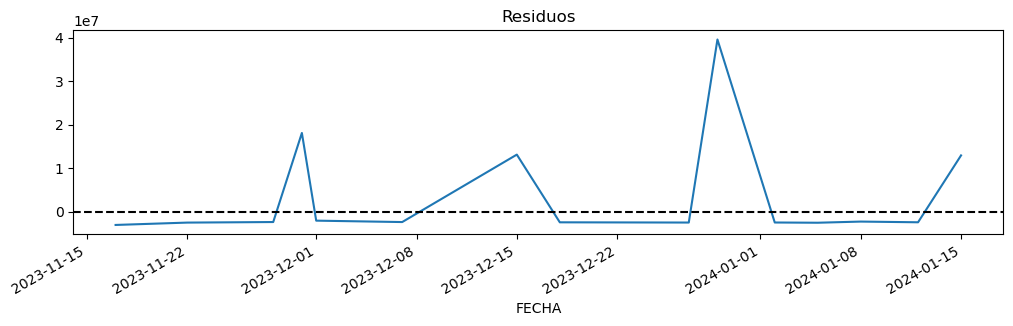

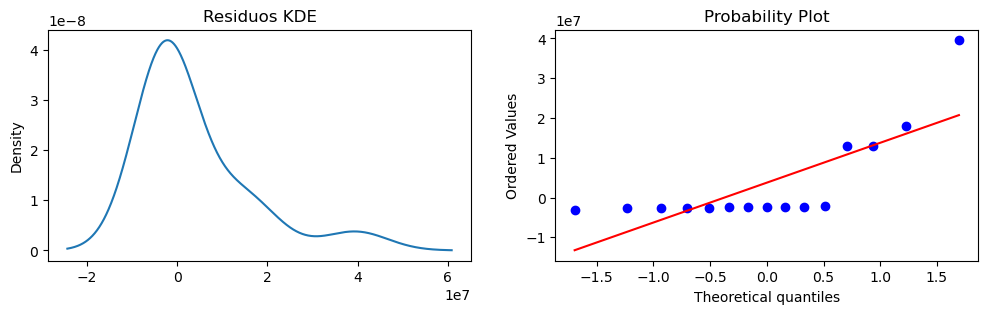

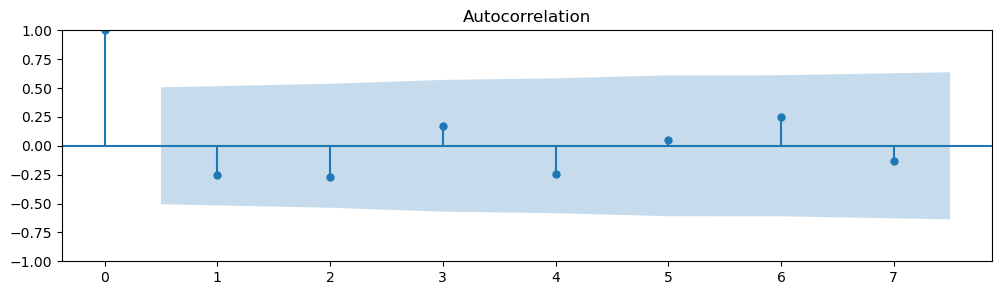

Descriptivo Residuos

count    1.500000e+01
mean     3.749568e+06
std      1.220583e+07
min     -3.076666e+06
25%     -2.518576e+06
50%     -2.411832e+06
75%      5.408812e+06
max      3.954531e+07
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.0006388435039525697

Shapiro
p-valor: 3.081531744487833e-05



In [225]:
print("CHU_COPA_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_COPA_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

In [ ]:
print("CHU_REC_PROPIOS_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_REC_PROPIOS_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

In [ ]:
print("CHU_REGALIAS_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_REGALIAS_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

## Ejercicio 11
Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad.

Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis

*Debemos ver cómo las variables en el modelo responden a un shock o perturbación en una de las variables.*

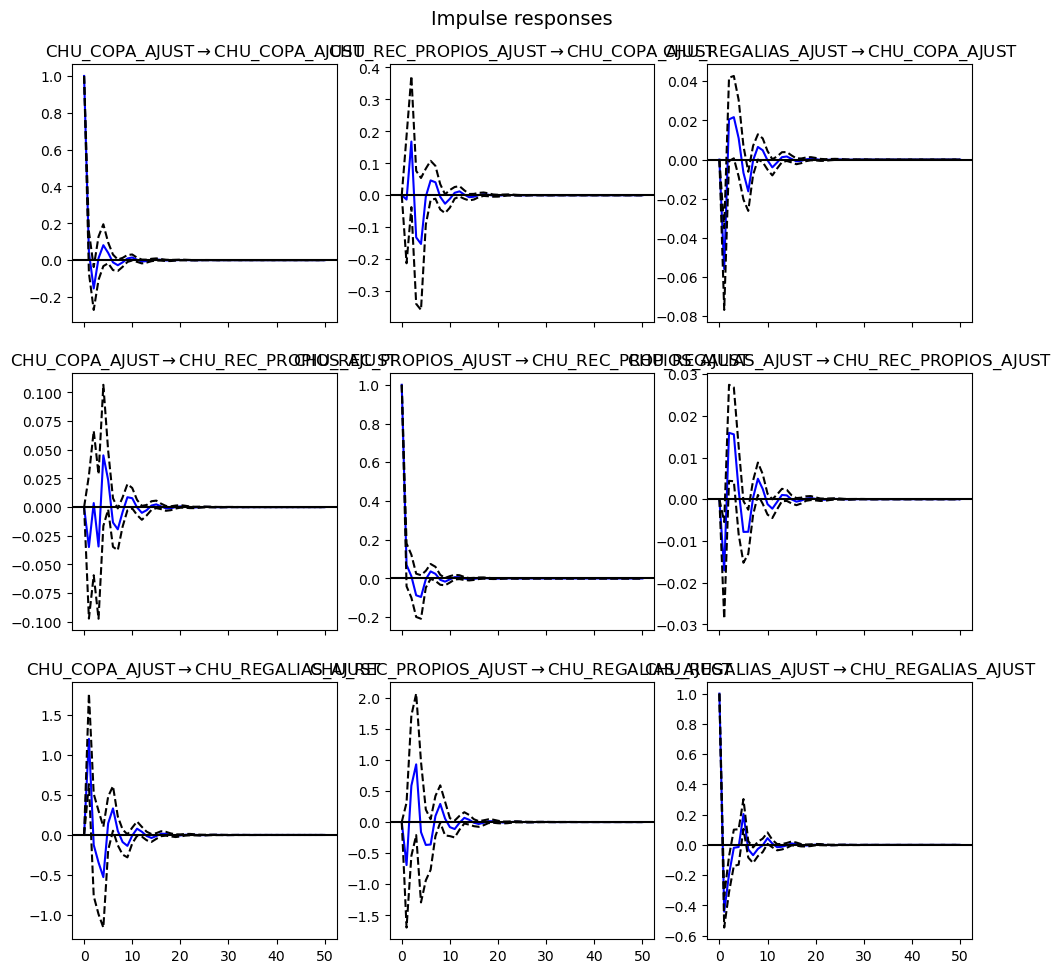

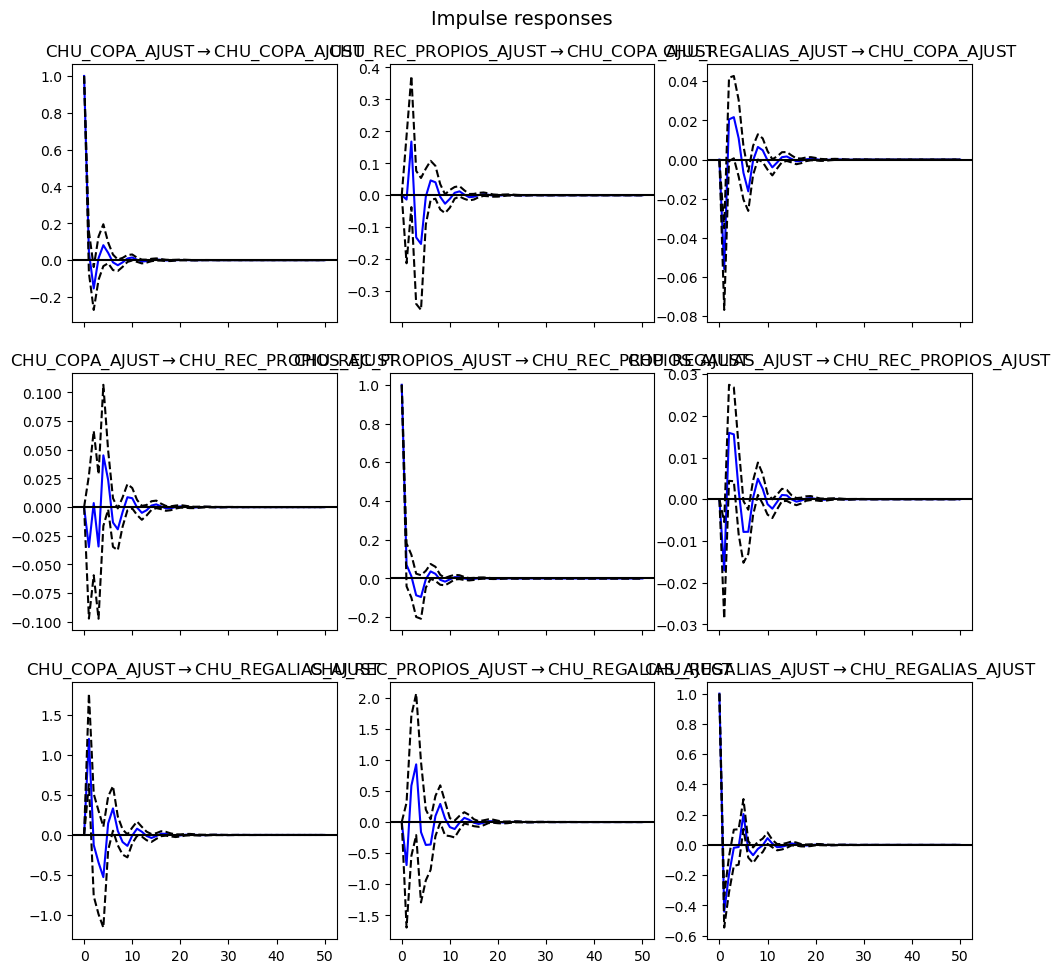

In [227]:
model_fitted.irf(50).plot()

## Ejercicio 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior.

(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9292b23b-d668-48da-87b9-72d6854ea93f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>